In [1]:
import pandas as pd
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import Dense

pd.options.mode.chained_assignment = None 

df = pd.read_csv('body_performance.csv')
df.shape

2023-05-07 15:06:31.110287: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(13067, 12)

### Body Performance Data

_O zbiorze danych_

Zbiór danych przedstawia dane pochodzące z _Korea Sports Promotion Foundation_. Zawiera 12 następujących kolumn: 
- wiek (od 20 do 64 lat)
- płeć (kobieta lub mężczyzna)
- wzrost (cm)
- waga (kg)
- body fat (%)
- diastolic (min) - ciśnienie rozkurczowe
- systolic (min) - ciśnienie skurczowe
- siła chwytu
- siad i skłon do przodu (cm)
- przysiady (liczba)
- skok w dal (cm)
- klasa (A,B,C,D), gdzie A to najlepsza klasa wyników sprawnościowych

Dataset ma około 13 tysięcy wierszy/danych.


##### Preprocessing

Preprocessing (przetwarzanie danych) to zbiór operacji, które są stosowane do surowych danych przed ich analizą lub modelowaniem. Przetwarzanie wstępne jest ważnym elementem procesu data science i uczenia maszynowego, ponieważ pozwala na odpowiednie formatowanie, czyszczenie i transformowanie danych, aby można je było skutecznie wykorzystać w modelowaniu lub analizie.

In [2]:
df.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,13067.0,36.756945,13.614536,21.0,25.0,32.0,48.0,64.0
height_cm,12959.0,168.547380,8.410802,125.0,162.4,169.2,174.7,193.8
weight_kg,12938.0,67.341096,11.855910,26.3,58.1,67.4,75.2,138.1
body fat_%,12955.0,23.135354,7.228554,3.0,17.9,22.7,27.9,78.4
diastolic,12946.0,78.783879,10.741310,0.0,71.0,79.0,86.0,156.2
systolic,12958.0,130.240847,14.700426,0.0,120.0,130.0,141.0,201.0
gripForce,12924.0,36.977987,10.623188,0.0,27.5,37.9,45.2,70.5
sit and bend forward_cm,12943.0,15.408594,8.335616,-25.0,11.1,16.3,20.9,213.0
sit-ups counts,12950.0,39.988494,14.170690,0.0,31.0,42.0,51.0,80.0
broad jump_cm,12950.0,190.543328,39.672738,0.0,163.0,193.0,222.0,303.0


Powyżej wyświetlone dane wskazują na pewne nieprawidłowości, co poniektóre mogą nawet wskazywać na zagrożenie zdrowia lub życia, to znaczy: 
- nieprawdopodobne wartości wagi dla dorosłej kobiety, np. 26.3 kg 
- sit and bend forward - niemożliwa maksymalna wartość pochylenia się przez człowieka
- diastolic oraz systolic mają wartości, które znacząco przekraczają normy
<center><img src="bloodpressure.png"/></center>

Co więcej, baza posiada duplikaty.

In [4]:
df.duplicated().sum()
print('W data set znajduje się {} duplikat.'.format(df.duplicated().sum()))
duplicate = df[df.duplicated()]
duplicate

W data set znajduje się 1 duplikat.


,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
12169,27.0,F,157.0,49.1,30.7,70.0,86.0,27.7,19.7,51.0,167.0,A


In [5]:
df.drop_duplicates(inplace=True)

Istnieją również wartości puste (N/A) - not applicable.

In [6]:
df.isna().sum()

age                          0
gender                       0
height_cm                  108
weight_kg                  129
body fat_%                 112
diastolic                  121
systolic                   109
gripForce                  143
sit and bend forward_cm    124
sit-ups counts             117
broad jump_cm              117
class                        0
dtype: int64

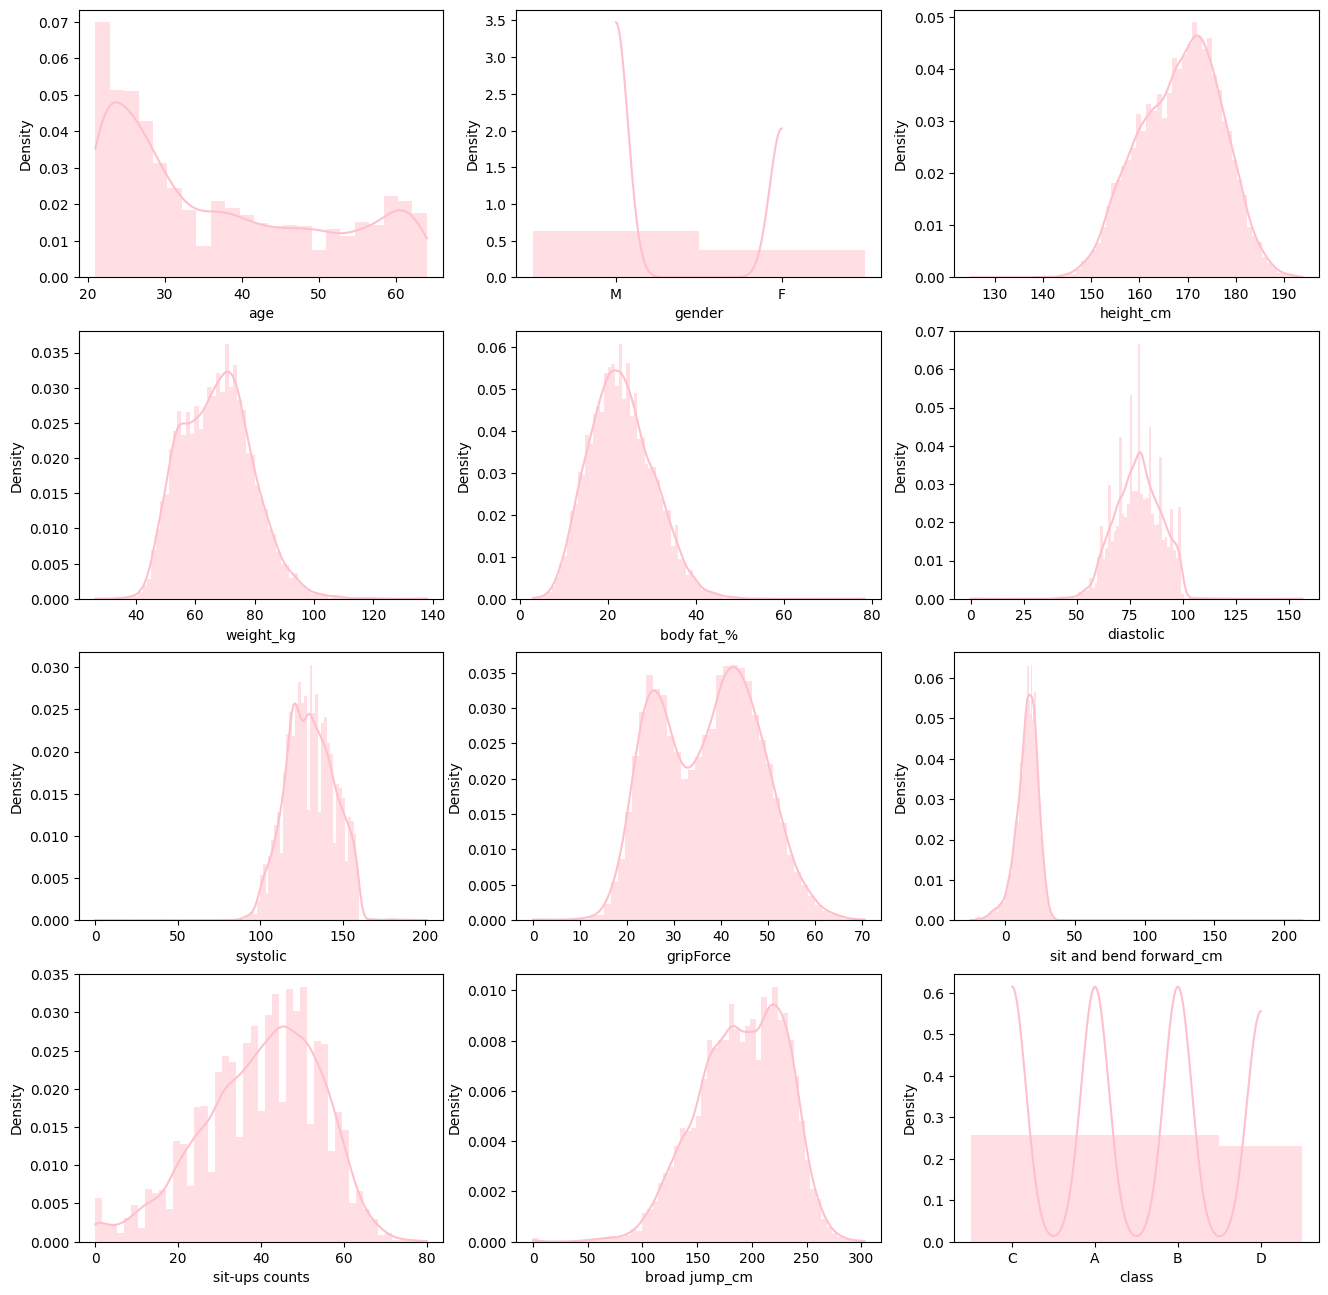

In [7]:
plt.figure (figsize=(16,16))

for i, column in enumerate(df.columns, 1):
    plt.subplot(4,3,i)
    sns.histplot(df[column], color="pink", kde=True, stat="density", linewidth=0)

##### Krok I - usuwanie błędnych danych

dane kategoryczne jakościowe

Niektóre pola _gender_ mają wpisane niepotrzebne cudzysłowia, a także zamiast podjedynczej litery całe słowo.

In [8]:
df['gender'] = df['gender'].replace({'F': 'F', "'F'": 'F', 'M': 'M', "'M'": 'M', 'Female': 'F', 'Male': 'M'})

outliers - dane odstające

In [9]:
df.sort_values('sit and bend forward_cm', ascending=False).head(3)

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
2594,33.0,M,165.6,60.4,17.8,81.0,127.0,38.6,213.0,53.0,244.0,B
3278,45.0,M,164.4,64.4,24.3,96.0,142.0,38.5,185.0,44.0,223.0,A
4105,46.0,M,164.4,63.6,23.4,70.0,115.0,36.0,42.0,42.0,210.0,A


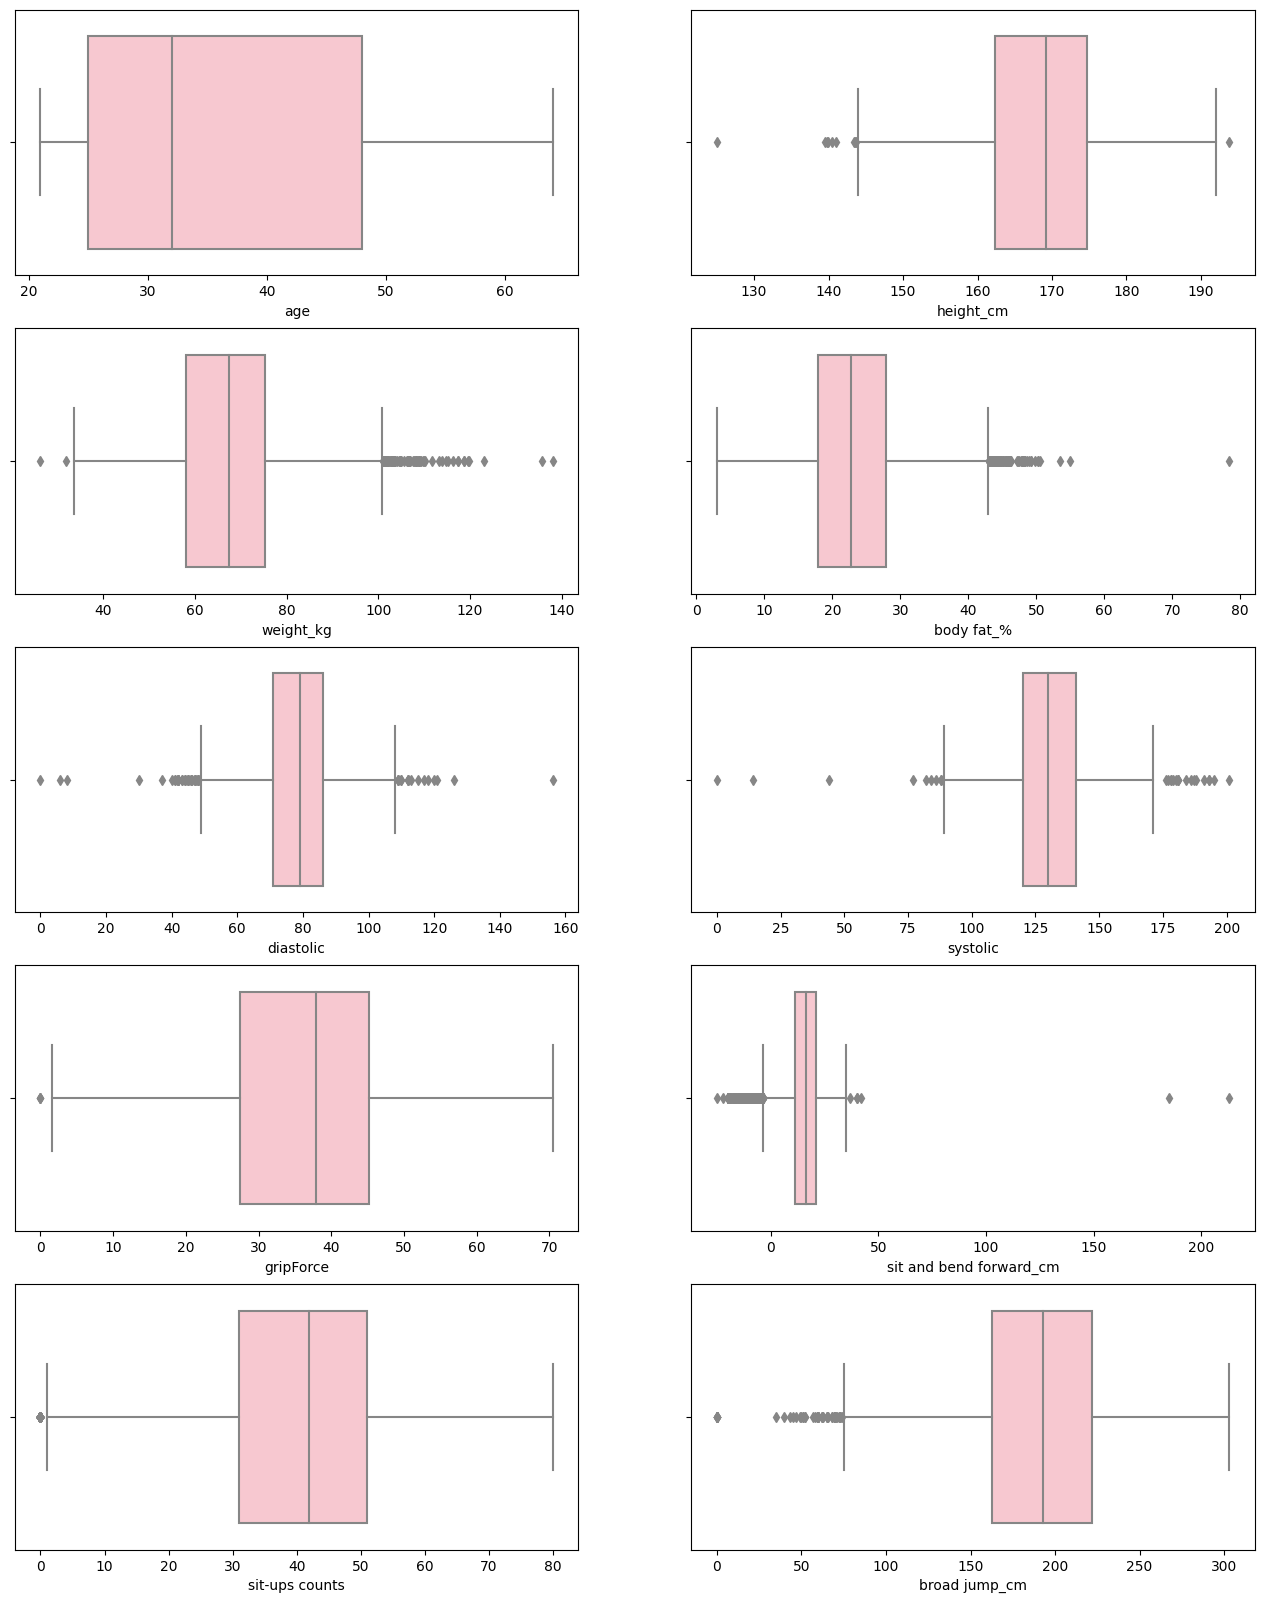

In [10]:
plt.figure (figsize=(16,20))
filteredCols = [c for c in df.columns if c != 'gender' and c != 'class']
for i, column in enumerate(filteredCols, 1):
    plt.subplot(5,2,i)
    sns.boxplot(x=df[column], color='pink')


Aby uniknąć modyfikacji oryginalnego data frame, tworzę kopię danych, na której będę pracować.

In [11]:
df_copy = df.copy()

Wybrałam z-score do identyfikacji wartości skrajnych, ponieważ jest to metoda, która pozwala na identyfikację wartości odstających na podstawie odchylenia standardowego od średniej. Metoda ta opiera się na normalnym rozkładzie danych i jest skuteczna w przypadku, gdy rozkład danych jest przybliżony do normalnego. W porównaniu z metodą IQR, która opiera się na kwartylach i medianie, z-score jest bardziej czuły na wartości skrajne i może lepiej identyfikować odstające obserwacje.

In [12]:
def find_outliers_z_score(df, threshold=3):
    mean = df.mean()
    std = df.std()
    df[(df - mean).abs() > threshold * std] = np.nan


_wzrost_

In [13]:
find_outliers_z_score(df_copy['height_cm'])

_waga_

In [14]:
find_outliers_z_score(df_copy['weight_kg'])

_tkanka tłuszczowa_

In [15]:
find_outliers_z_score(df_copy['body fat_%'])

_siła chwytu_

In [16]:
find_outliers_z_score(df_copy['gripForce'])

_siad i pochylenie się do przodu_

Zanim jednak wykorzystam funkcję z-score, usunę nieprawdiłowe wyniki ujemne, które funkcja nie będzie uważać za odstające.

In [17]:
find_outliers_z_score(df_copy['sit and bend forward_cm'])

_przysiady_

In [18]:
find_outliers_z_score(df_copy['sit-ups counts'])

_skok w dal_

In [19]:
find_outliers_z_score(df_copy['broad jump_cm'])

Aby wykluczyć nieprawidłowe wyniki krwi:

In [20]:
df_copy.loc[(df_copy['diastolic'] < 40) | (df_copy['diastolic'] > 100), 'diastolic'] = np.nan
df_copy.loc[(df_copy['systolic'] < 40) | (df_copy['systolic'] > 160), 'systolic'] = np.nan

In [21]:
df_copy.isna().sum()

age                          0
gender                       0
height_cm                  115
weight_kg                  182
body fat_%                 152
diastolic                  163
systolic                   140
gripForce                  154
sit and bend forward_cm    263
sit-ups counts             117
broad jump_cm              165
class                        0
dtype: int64

##### Krok II - usuwanie brakujących danych

Metoda KNN imputation jest jedną z metod _imputacji_ brakujących danych, czyli wypełniania pustych wartości w zbiorze danych. W tym podejściu brakujące wartości są uzupełniane na podstawie wartości sąsiadów, czyli innych wierszy w zbiorze danych, które są najbardziej podobne (w sensie odległości euklidesowej) do wiersza z brakującą wartością.

Wybrałam KNN, sposród metod takich jak uzupełnianie wartości średnią, medianą lub dominantą, ponieważ KNN imputation może dostarczyć bardziej dokładne wyniki. W uzupełnianiu wartości średnią, medianą lub dominantą, wartości brakujące są uzupełniane na podstawie wartości reszty zbioru danych, co może prowadzić do przesunięcia centralnej tendencji i zfałszowania analizy. Z kolei KNN imputation wykorzystuje podobne wiersze, które mają podobne cechy, w tym przypadku klasa _body performance_ oraz _płeć_ (istotny czynnik wpływający na resztę zmiennych), co pozwala na zachowanie dokładności analizy.

In [ ]:
def knnImputer(df, column):
    missing_rows = df[df[column].isna()]
    
    for i, row in missing_rows.iterrows():
        same_class_rows = df[(df['class'] == row['class']) & (df['gender'] == df['gender'])]
        # KNNImputer requires complete rows
        same_class_rows = same_class_rows.dropna()
        fea_transformer = KNNImputer(n_neighbors=20)
        imputed_value = fea_transformer.fit_transform(same_class_rows[[column]])
        # Replace the missing value with the imputed value
        # print(df.loc[i])
        # print(imputed_value[0][0])
        df.loc[i, column] = imputed_value[0][0]
            
    return pd.DataFrame(df)

In [23]:
df_copy = knnImputer(df_copy, 'height_cm')
df_copy = knnImputer(df_copy, 'weight_kg')
df_copy = knnImputer(df_copy, 'body fat_%')
df_copy = knnImputer(df_copy, 'diastolic')
df_copy = knnImputer(df_copy, 'systolic')
df_copy = knnImputer(df_copy, 'gripForce')
df_copy = knnImputer(df_copy, 'sit and bend forward_cm')
df_copy = knnImputer(df_copy, 'sit-ups counts')
df_copy = knnImputer(df_copy, 'broad jump_cm')

age                         23.0
gender                         F
height_cm                    NaN
weight_kg                   64.2
body fat_%                  29.2
diastolic                   55.0
systolic                   102.0
gripForce                   29.9
sit and bend forward_cm     14.6
sit-ups counts              27.0
broad jump_cm              126.0
class                          C
Name: 147, dtype: object
172.3
age                         56.0
gender                         F
height_cm                    NaN
weight_kg                   54.7
body fat_%                  37.7
diastolic                   85.0
systolic                   125.0
gripForce                   22.7
sit and bend forward_cm     10.7
sit-ups counts               0.0
broad jump_cm              134.0
class                          D
Name: 187, dtype: object
164.5
age                         26.0
gender                         M
height_cm                    NaN
weight_kg                   73.4
body fat_%    

In [24]:
df_copy.isna().sum()

age                        0
gender                     0
height_cm                  0
weight_kg                  0
body fat_%                 0
diastolic                  0
systolic                   0
gripForce                  0
sit and bend forward_cm    0
sit-ups counts             0
broad jump_cm              0
class                      0
dtype: int64

Nie istnieje jednoznaczna klasyfikacja sprawości ciała, stąd dla jasności wyników dzielę klasyfikacje i oznaczam A, B jako dobrą, a C, D jako słabą/złą.

In [25]:
df_copy['class'] = df_copy['class'].replace({'A': 'good', 'B': 'good', 'C': 'bad', 'D': 'bad'})

##### Krok III, IV - optymalizowanie struktury zbioru danych oraz normalizacja danych

In [26]:
df_copy.describe(include="object")

,gender,class
count,13066,13066
unique,2,2
top,M,good
freq,8249,6694


In [27]:
df_copy['gender'] = df_copy['gender'].map({'F': 0, 'M': 1})

In [28]:
df_copy['class'].value_counts()

good    6694
bad     6372
Name: class, dtype: int64

In [29]:
df_copy['class'] = df_copy['class'].map({'good': 0, 'bad': 1})

df_copy['class'].value_counts()

0    6694
1    6372
Name: class, dtype: int64

Dysproporcje pomiędzy wartościami klas są nieznaczne, stąd nie będę wykonywać żadnej techniki wyrównywania wartości.

In [30]:
df_copy.describe()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
count,13066.000000,13066.000000,13066.000000,13066.000000,13066.000000,13066.000000,13066.000000,13066.000000,13066.000000,13066.000000,13066.000000,13066.000000
mean,36.757692,0.631333,168.565008,67.153674,23.078846,78.694237,130.196916,36.995026,15.504380,40.052197,191.071338,0.487678
std,13.614789,0.482462,8.356354,11.492152,7.097786,10.486017,14.399259,10.590080,7.584312,14.195507,38.740071,0.499867
min,21.000000,0.000000,143.400000,31.900000,3.000000,40.000000,43.900000,5.300000,-9.500000,0.000000,72.000000,0.000000
25%,25.000000,0.000000,162.500000,58.100000,17.900000,71.000000,120.000000,27.500000,11.100000,31.000000,163.000000,0.000000
50%,32.000000,1.000000,169.200000,67.270000,22.600000,79.000000,130.000000,37.900000,16.300000,42.000000,194.000000,0.000000
75%,48.000000,1.000000,174.700000,75.100000,27.900000,86.000000,141.000000,45.200000,20.800000,51.000000,222.000000,1.000000
max,64.000000,1.000000,192.000000,102.900000,44.800000,100.000000,160.000000,68.400000,40.000000,80.000000,303.000000,1.000000


BMI (Body Mass Index) to wskaźnik masy ciała powstały przez podzielenie masy ciała (w kilogramach) przez kwadrat wysokości (w metrach). Wynik BMI pozwala na ocenę wagi ciała i określenie, czy dana osoba ma niedowagę, wagę prawidłową, nadwagę czy otyłość.
Warto zamienić kolumny weight i height na BMI, ponieważ pozwoli to na uzyskanie jednej kolumny, 
która będzie reprezentować wskaźnik masy ciała każdej osoby. Dzięki temu łatwiej będzie wykryć zależności pomiędzy tymi dwoma kolumnami i identyfikacje osób
z niedowagą, nadwagą lub otyłością.


In [31]:
# zamiana jednostki z cm na m
df_copy['height_cm'] = df_copy['height_cm'] / 100

# nowa kolumna bmi
df_copy['BMI'] = df_copy['weight_kg'] / (df_copy['height_cm'] ** 2)

# zaokrąglenie do 2 miejsc po przecinku, ponieważ BMI ma taki format
df_copy['BMI'] = df_copy['BMI'].round(2)

# dodanie kolumny BMI jako przedostatniej kolumny
df_copy.insert(len(df_copy.columns) - 2, 'BMI', df_copy.pop('BMI'))

# usunięcie niepotrzebnych już kolumn
df_copy.drop(['weight_kg', 'height_cm'], axis=1, inplace=True)

df_copy.head()

,age,gender,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,BMI,class
0,27.0,1,21.3,80.0,130.0,54.9,18.4,60.0,217.0,25.34,1
1,25.0,1,15.7,77.0,126.0,36.4,16.3,53.0,229.0,20.50,0
2,31.0,1,20.1,92.0,152.0,44.8,12.0,49.0,181.0,24.18,1
3,32.0,1,18.4,76.0,147.0,41.4,15.2,53.0,219.0,23.35,0
4,28.0,1,17.1,70.0,127.0,43.5,27.1,45.0,217.0,22.41,0


Zróżnoważenie danych

PCA (Principal Component Analysis) to jedna z popularnych metod analizy danych, wykorzystywana do redukcji wymiarowości danych. 
Polega ona na transformacji danych wejściowych na nowe wymiary, nazywane składowymi głównymi (komponenty),
które reprezentują większość informacji zawartej w danych pierwotnych.

PCA działa poprzez wyznaczenie kierunków o największej zmienności w danych i transformację danych wejściowych na nowe kierunki,
 które niosą ze sobą większość informacji. Składowe główne są uporządkowane według ich znaczenia,
  z najważniejszą składową na początku, co pozwala na redukcję wymiarów danych, zachowując jednocześnie jak najwięcej informacji.

Ważne jest, aby najpierw przeskalować dane w zakresie od 0 do 1.
PCA jest wrażliwe na różnice w skali danych, co oznacza, że jeśli mamy kolumny o bardzo różnych zakresach wartości,
to PCA może być bardziej skłonny do wzięcia pod uwagę tych kolumn o większej skali.

Dlatego zwykle normalizuje się dane przed PCA, aby upewnić się, że każda kolumna jest równie ważna i ma podobny wpływ na wynik końcowy PCA.
_Normalizacja Min-Max_ przeskalowuje wartości w zakresie od 0 do 1, co zapewnia, 
że ​​każda kolumna jest przetwarzana w podobnym zakresie wartości i pomaga uniknąć błędów związanych z różnicami w skali.

Taki proces przeskalowania wartości pozwoli zachować istotność każdego komponentu cech, a wyniki analizy będą bardziej miarodajne.

In [32]:
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(df_copy)

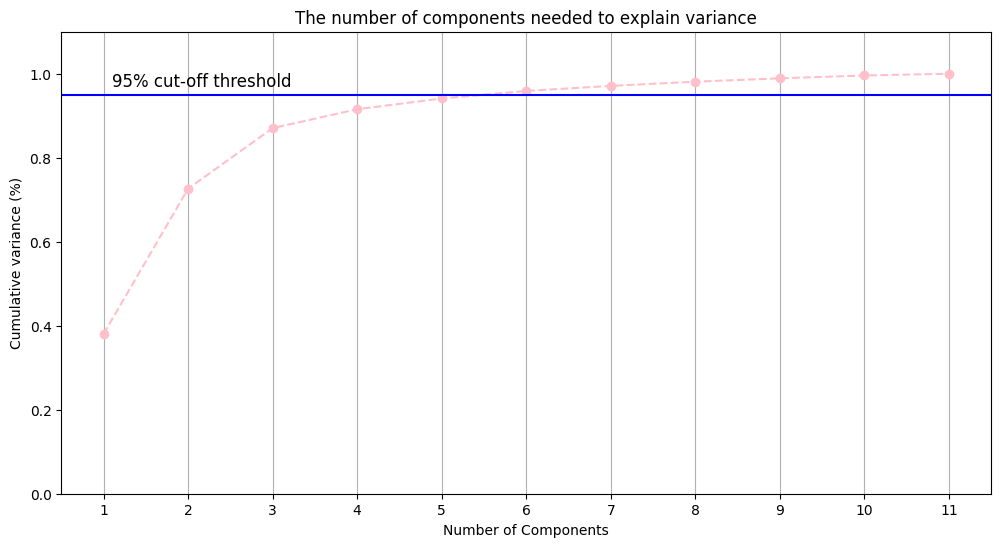

In [33]:
pca = PCA().fit(data_rescaled)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 12, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='pink')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 12, step=1))

plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='b', linestyle='-')
plt.text(1.1, 0.97, '95% cut-off threshold', color = 'black', fontsize=12)

ax.grid(axis='x')
plt.show()


Z powyższego wykresu wynika, że 95% wariancji można wyjaśnić przy użyciu 6 komponentów.

In [34]:
X = df_copy.drop('class', axis=1)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_copy['class'] = le.fit_transform(df_copy['class'])
y = df_copy['class']

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Wykonanie PCA
# pca = PCA(n_components=6)
pca = PCA(n_components = 0.95)
X_pca = pca.fit_transform(X)

# Tworzenie nowego obiektu DataFrame z wynikami PCA
X_pca_df = pd.DataFrame(X_pca)

# Wypisanie wyników
print(X_pca_df.head())
print(y.head())

          0         1         2         3         4         5
0 -0.506924 -0.217119 -0.031759 -0.067878 -0.155213 -0.063366
1 -0.445159 -0.271492  0.075851 -0.009305  0.110680  0.082659
2 -0.430700 -0.002700 -0.247888 -0.018572  0.075095  0.002677
3 -0.443181 -0.085123  0.018458 -0.039530  0.013623 -0.004744
4 -0.405900 -0.210534  0.175932 -0.081562 -0.084792  0.213675
0    1
1    0
2    1
3    0
4    0
Name: class, dtype: int64


##### Krok V - testowanie klasyfikatorów

In [35]:
(train_data, test_data, train_labels, test_labels) = train_test_split(X_pca_df, y, train_size=0.7, random_state=277986)

Decision Tree Classfier

Decision Tree Classifier to algorytm uczenia maszynowego z grupy drzew decyzyjnych. Polega na budowie drzewa decyzyjnego na podstawie danych treningowych, które może być użyte do przewidywania wartości na zbiorze testowym.
Drzewo decyzyjne składa się z węzłów i krawędzi, gdzie węzły reprezentują atrybuty, a krawędzie reprezentują wartości tych atrybutów. Korzeń drzewa (główny węzeł) reprezentuje atrybut, który najlepiej rozdziela zbiór danych wejściowych, a liście drzewa reprezentują klasy, do których przyporządkowane są rekordy.

Głębokość drzewa określa liczbę warstw decyzji potrzebnych do podjęcia decyzji o klasyfikacji. Im większa liczba gałęzi (głębokość drzewa), tym bardziej złożone modele mogą być tworzone, ponieważ drzewa będą w stanie wykryć bardziej złożone relacje pomiędzy zmiennymi w danych wejściowych.
Jednak, zbyt duża głębokość drzewa może prowadzić do nadmiernego dopasowania do danych treningowych, co oznacza, że model będzie działał dobrze na danych treningowych, ale słabo na danych testowych. 

_wersja głębsza_

DD Accuracy: 79.34%


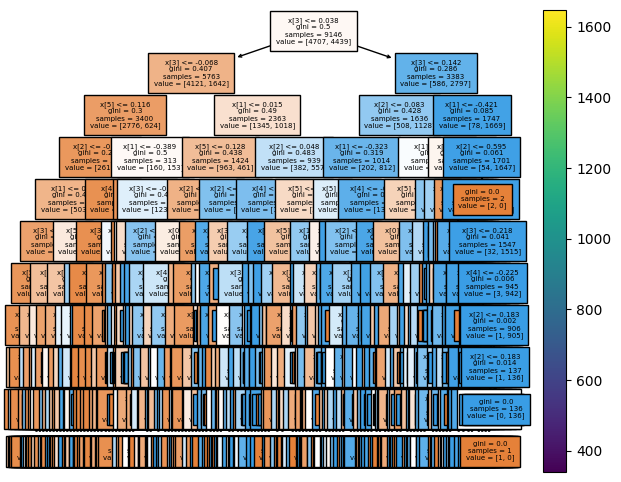

In [36]:
tree_classifier = DecisionTreeClassifier(random_state=277986, max_depth=10)

train_inputs = train_data
train_classes = train_labels
test_inputs = test_data
test_classes = test_labels

tree_classifier.fit(train_inputs, train_classes)

tree_predictions = tree_classifier.predict(test_inputs)
tree_accuracy = accuracy_score(test_classes, tree_predictions)
tree_cm = confusion_matrix(test_classes, tree_predictions)

print("DD Accuracy: {:.2f}%".format(tree_accuracy * 100))

predictions = tree_classifier.predict(test_inputs)
cm = confusion_matrix(test_classes, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree_classifier.classes_)
disp.plot()

plot_tree(tree_classifier, filled=True, fontsize=5)
plt.show()

_wersja płytsza_

DD Accuracy: 77.50%


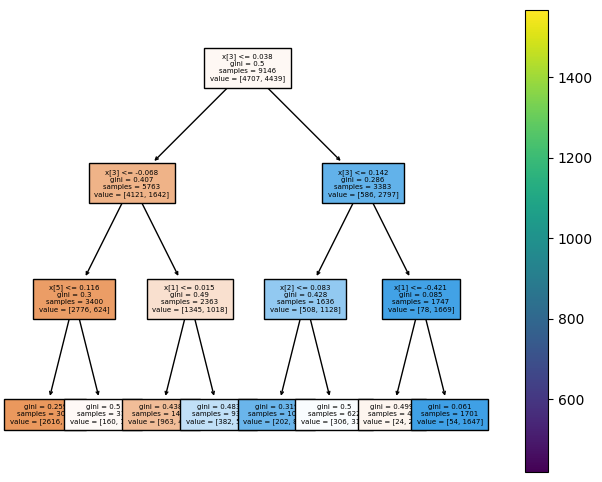

In [37]:
tree_classifier = DecisionTreeClassifier(random_state=277986, max_depth=3)

train_inputs = train_data
train_classes = train_labels
test_inputs = test_data
test_classes = test_labels

tree_classifier.fit(train_inputs, train_classes)

tree_predictions = tree_classifier.predict(test_inputs)
tree_accuracy = accuracy_score(test_classes, tree_predictions)
tree_cm = confusion_matrix(test_classes, tree_predictions)

print("DD Accuracy: {:.2f}%".format(tree_accuracy * 100))

predictions = tree_classifier.predict(test_inputs)
cm = confusion_matrix(test_classes, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree_classifier.classes_)
disp.plot()

plot_tree(tree_classifier, filled=True, fontsize=5)
plt.show()

Naiwny Bayes

Algorytm Naive Bayes to probabilistyczna metoda klasyfikacji, która opiera się na teorii Bayesa. Dla danego zbioru cech, algorytm oblicza prawdopodobieństwo, że dany obiekt należy do danej klasy, na podstawie prawdopodobieństw a priori danej klasy oraz prawdopodobieństw warunkowych cech dla każdej klasy. Opiera się na twierdzeniu Bayesa, zakładającym niezależność cech od siebie. Innymi słowy, algorytm zakłada, że obecność jednej cechy nie wpływa na obecność innej cechy. To przybliżenie rzeczywistości może nie być zawsze prawdziwe, ale pozwala na zastosowanie prostych i szybkich obliczeń.

Naive Bayes Accuracy: 82.50%


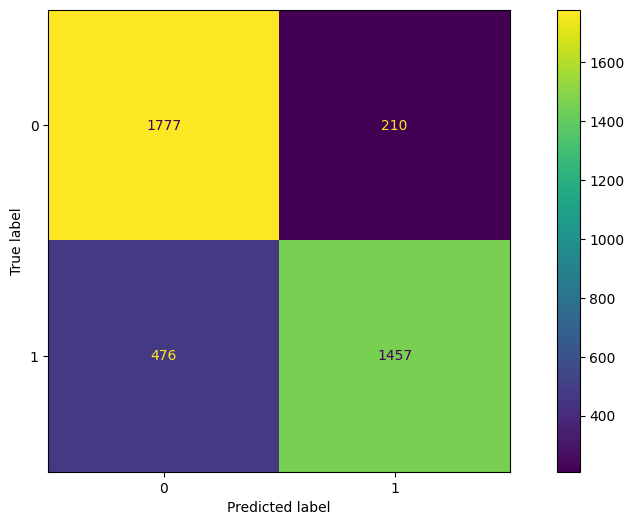

In [38]:
nb = GaussianNB()

train_inputs = train_data
train_classes = train_labels
test_inputs = test_data
test_classes = test_labels

nb.fit(train_inputs, train_classes)
nb_predictions = nb.predict(test_inputs)
nb_accuracy = accuracy_score(test_classes, nb_predictions)
nb_cm = confusion_matrix(test_classes, nb_predictions)

print("Naive Bayes Accuracy: {:.2f}%".format(nb_accuracy * 100))

predictions = nb.predict(test_inputs)
cm = confusion_matrix(test_classes, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb.classes_)
disp.plot()

Można zauważyć, że więcej klas złych jest przewidywane jako dobre, niż odwrotnie.

K-Nearest Neighbors

KNN (K-Nearest Neighbors) to prosty algorytm klasyfikacji, który działa na zasadzie przypisania nowego przykładu do klasy już znanej z najbliższych mu sąsiadów. Wymaga wcześniejszego określenia liczby sąsiadów (parametru k), którzy będą brani pod uwagę przy klasyfikacji. Klasyfikacja odbywa się przez głosowanie, gdzie k najbliższych sąsiadów "głosuje" na swoją klasę, a nowy przykład jest przypisywany do klasy, która zdobyła najwięcej głosów. W przypadku remisu, klasa jest losowana, dlatego wybieram k nieparzyste.

k-NN with k=3

3-NN Accuracy: 80.41%


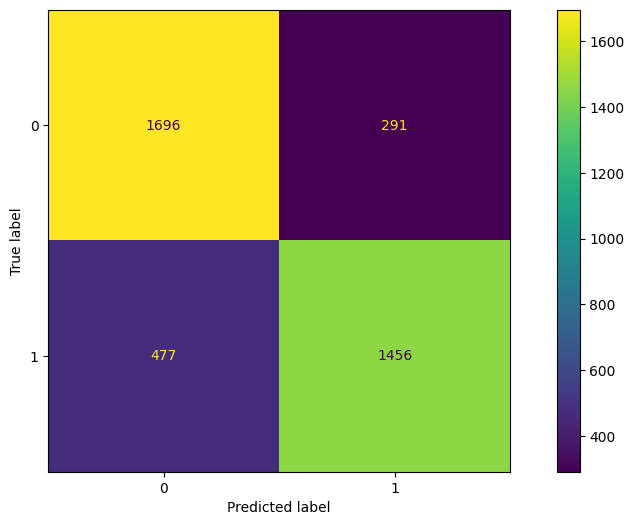

In [39]:
knn_3 = KNeighborsClassifier(n_neighbors=3)

train_inputs = train_data
train_classes = train_labels
test_inputs = test_data
test_classes = test_labels

knn_3.fit(train_inputs, train_classes)
knn_3_predictions = knn_3.predict(test_inputs)
knn_3_accuracy = accuracy_score(test_classes, knn_3_predictions)
knn_3_cm = confusion_matrix(test_classes, knn_3_predictions)

print("3-NN Accuracy: {:.2f}%".format(knn_3_accuracy * 100))

predictions = knn_3.predict(test_inputs)
cm = confusion_matrix(test_classes, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_3.classes_)
disp.plot()

k-NN with k = 5

5-NN Accuracy: 81.91%


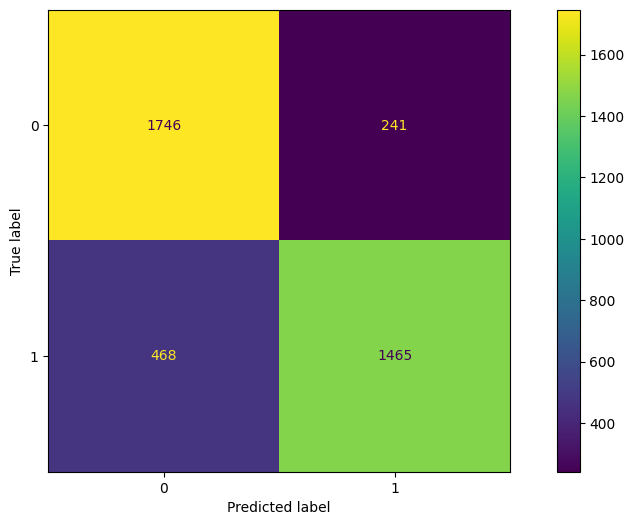

In [40]:
knn_5 = KNeighborsClassifier(n_neighbors=5)

train_inputs = train_data
train_classes = train_labels
test_inputs = test_data
test_classes = test_labels

knn_5.fit(train_inputs, train_classes)
knn_5_predictions = knn_5.predict(test_inputs)
knn_5_accuracy = accuracy_score(test_classes, knn_5_predictions)
knn_5_cm = confusion_matrix(test_classes, knn_5_predictions)

print("5-NN Accuracy: {:.2f}%".format(knn_5_accuracy * 100))

predictions = knn_5.predict(test_inputs)
cm = confusion_matrix(test_classes, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_5.classes_)
disp.plot()

k-NN with k = 11

11-NN Accuracy: 82.55%


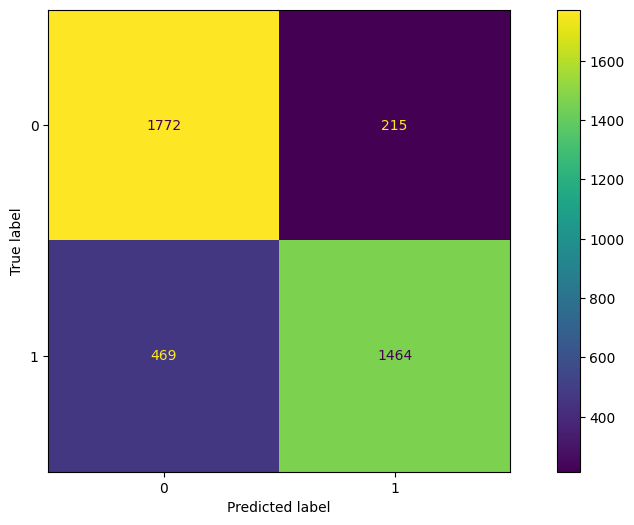

In [41]:
knn_11 = KNeighborsClassifier(n_neighbors=11)

train_inputs = train_data
train_classes = train_labels
test_inputs = test_data
test_classes = test_labels

knn_11.fit(train_inputs, train_classes)
knn_11_predictions = knn_11.predict(test_inputs)
knn_11_accuracy = accuracy_score(test_classes, knn_11_predictions)
knn_11_cm = confusion_matrix(test_classes, knn_11_predictions)

print("11-NN Accuracy: {:.2f}%".format(knn_11_accuracy * 100))

predictions = knn_11.predict(test_inputs)
cm = confusion_matrix(test_classes, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_11.classes_)
disp.plot()

MLP Classifier

MLP to skrót od Multi-Layer Perceptron, który jest jednym z najpopularniejszych rodzajów sztucznych sieci neuronowych. MLP składa się z co najmniej trzech warstw neuronów: warstwy wejściowej, warstwy wyjściowej i jednej lub więcej warstw ukrytych. W MLP każdy neuron w warstwie ukrytej otrzymuje wejścia od wszystkich neuronów w poprzedniej warstwie i przetwarza je, wykorzystując określoną funkcję aktywacji. MLP jest wykorzystywany do klasyfikacji, regresji i wielu innych zadań przetwarzania danych, a proces uczenia polega na dopasowaniu wag neuronów w sieci do wejściowych danych treningowych.

Adam i L-BFGS są dwoma popularnymi solverami używanymi w algorytmach uczenia maszynowego. Oba rozwiązują problem optymalizacji funkcji kosztu, ale stosowane są w różnych kontekstach.

- Adam jest jednym z najpopularniejszych solverów stosowanych w sieciach neuronowych. Jest to adaptacyjna metoda optymalizacji gradientu stochastycznego, która działa dobrze w przypadku dużych zbiorów danych i rzadkich gradientów. Adam może przyspieszyć zbieżność algorytmu i zazwyczaj działa dobrze dla większości problemów uczenia maszynowego.

- L-BFGS to ograniczony algorytm BFGS, który jest popularny w algorytmach optymalizacji nieliniowej. Jest to metoda drugiego rzędu, która wykorzystuje informacje o drugiej pochodnej funkcji kosztu w celu aktualizacji wag.

ReLU i Tanh to funkcje aktywacji stosowane w sieciach neuronowych, w szczególności w warstwach ukrytych.

- ReLU (Rectified Linear Unit) to funkcja zwracająca 0 dla wartości ujemnych i x dla wartości dodatnich (f(x) = max(0, x)). ReLU jest stosowane, ponieważ działa szybciej niż niektóre inne funkcje aktywacji, takie jak sigmoida czy tanh, i często daje lepsze wyniki w praktyce.

- Tanh (tangens hiperboliczny) to funkcja aktywacji z zakresu (-1,1), która zwraca wartości ujemne dla argumentów ujemnych, bliskie 0 dla argumentów bliskich 0 i wartości dodatnie dla argumentów dodatnich. Tanh jest bardziej wygładzoną wersją funkcji sigmoidalnej i często stosuje się ją w warstwach ukrytych sieci neuronowych.

Time: 3.13 seconds
Accuracy on train data set: 84.53% with options ['relu', 'adam']
Accuracy on test data set: 84.41% with options ['relu', 'adam']

Time: 4.49 seconds
Accuracy on train data set: 84.54% with options ['tanh', 'adam']
Accuracy on test data set: 84.64% with options ['tanh', 'adam']

Time: 1.24 seconds
Accuracy on train data set: 85.79% with options ['relu', 'lbfgs']
Accuracy on test data set: 85.48% with options ['relu', 'lbfgs']

Time: 5.39 seconds
Accuracy on train data set: 86.45% with options ['tanh', 'lbfgs']
Accuracy on test data set: 86.25% with options ['tanh', 'lbfgs']



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


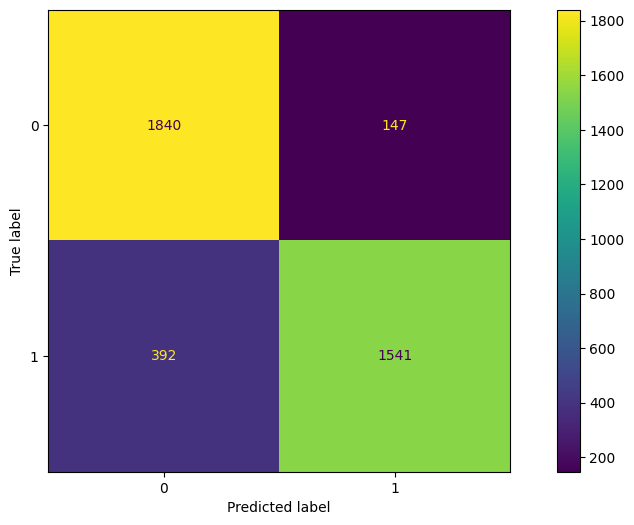

In [42]:
options = [['relu', 'adam'], ['tanh', 'adam'], ['relu', 'lbfgs'], ['tanh', 'lbfgs']]

for option in options:
    mlp = MLPClassifier(hidden_layer_sizes=(6,), max_iter=3000, activation=option[0], solver=option[1], random_state=277986)

    train_inputs = train_data
    train_classes = train_labels
    test_inputs = test_data
    test_classes = test_labels
    
    start_time = time.time()
    mlp.fit(train_inputs, train_classes.values.ravel())
    
    predictions_train = mlp.predict(train_inputs)
    predictions_test = mlp.predict(test_inputs)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print("Time: {:.2f} seconds".format(elapsed_time))
    print("Accuracy on train data set: {:.2f}% with options {}".format(accuracy_score(predictions_train, train_classes) * 100, option))
    print("Accuracy on test data set: {:.2f}% with options {}".format(accuracy_score(predictions_test, test_classes) * 100, option), end='\n\n')


cm = confusion_matrix(test_classes, predictions_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)
disp.plot()

Uważam, że najlepszym wyborem jest połączenie „tanh” i „adam”, ponieważ daje drugi najlepszy wynik bez ostrzeżenia o przekroczeniu limitu. Dzięki czemu jest wydajny i osiąga podobne dobre wyniki, co „tanh” i „lbfgs”.

Wybór odpowiednich warstw ukrytych (layers) w MLP zależy od wielu czynników, takich jak rozmiar i złożoność danych, dostępne zasoby obliczeniowe.  Wybór zbyt dużej liczby warstw lub ich rozmiaru może prowadzić do zjawiska overfittingu, czyli sytuacji, w której model zbyt dobrze dopasowuje się do danych treningowych, ale słabo generalizuje na nowych, nieznanych danych. Dlatego też ważne jest, aby zwrócić uwagę na wyniki na zbiorze testowym i unikać zbyt dużej złożoności modelu, jeśli nie jest to konieczne.

Time: 5.34 seconds
Accuracy on train data set: 84.98% with layers (12, 12)
Accuracy on test data set: 84.82% with layers (12, 12)

Time: 3.71 seconds
Accuracy on train data set: 85.08% with layers (12, 12, 12)
Accuracy on test data set: 84.90% with layers (12, 12, 12)

Time: 5.28 seconds
Accuracy on train data set: 85.23% with layers (24, 12)
Accuracy on test data set: 84.77% with layers (24, 12)

Time: 5.36 seconds
Accuracy on train data set: 84.99% with layers (11, 11)
Accuracy on test data set: 84.59% with layers (11, 11)

Time: 2.80 seconds
Accuracy on train data set: 84.81% with layers (12, 6, 3)
Accuracy on test data set: 84.52% with layers (12, 6, 3)

Time: 4.35 seconds
Accuracy on train data set: 85.26% with layers (24, 12, 6)
Accuracy on test data set: 85.10% with layers (24, 12, 6)

Time: 4.89 seconds
Accuracy on train data set: 85.51% with layers (24, 12, 12)
Accuracy on test data set: 85.26% with layers (24, 12, 12)

Time: 4.37 seconds
Accuracy on train data set: 85.40% wit

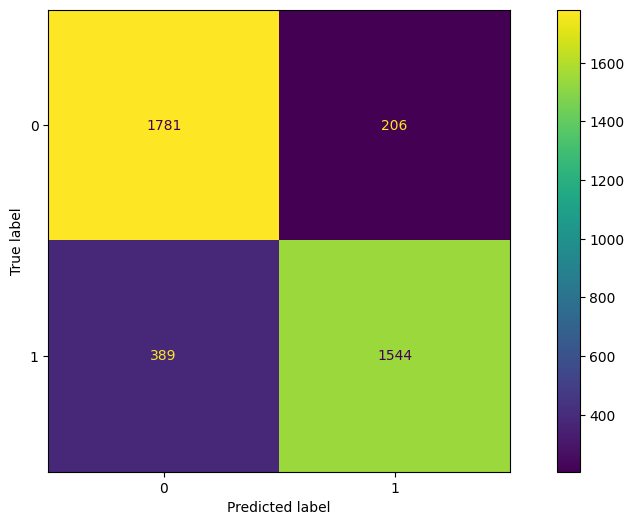

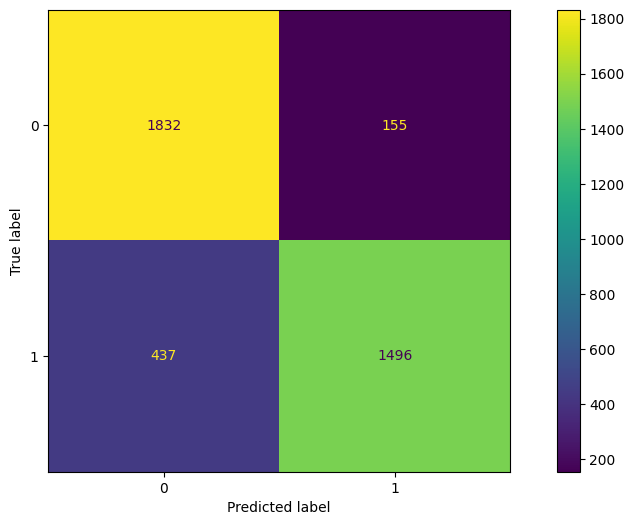

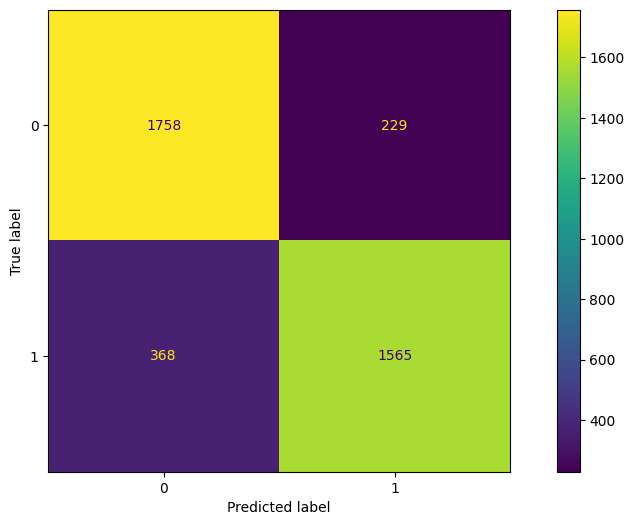

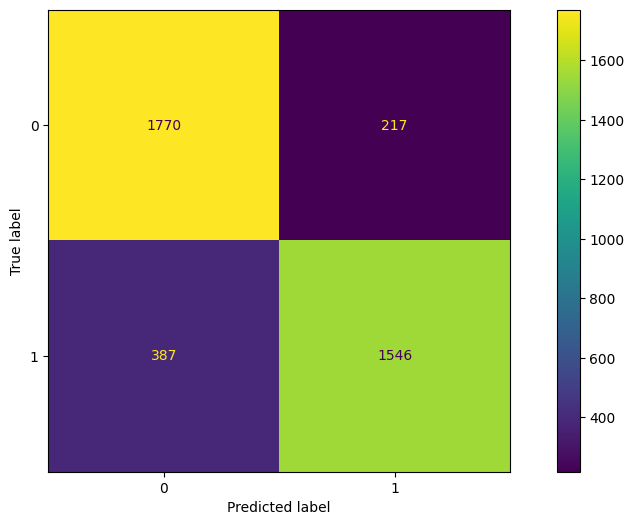

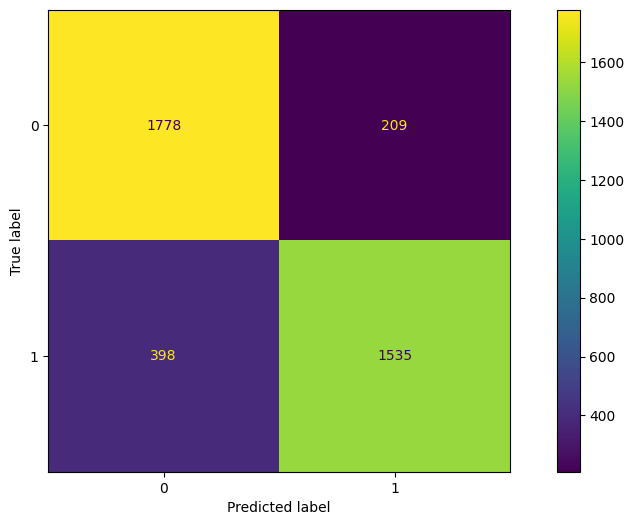

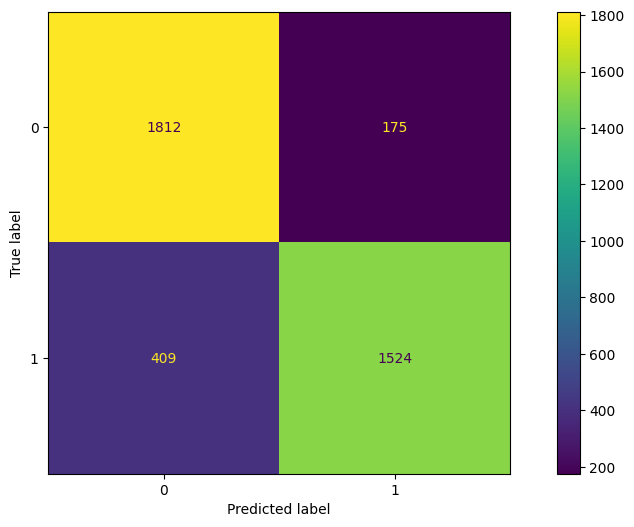

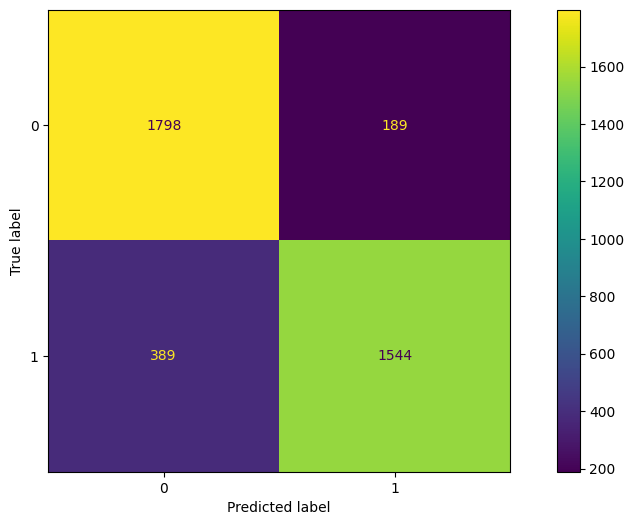

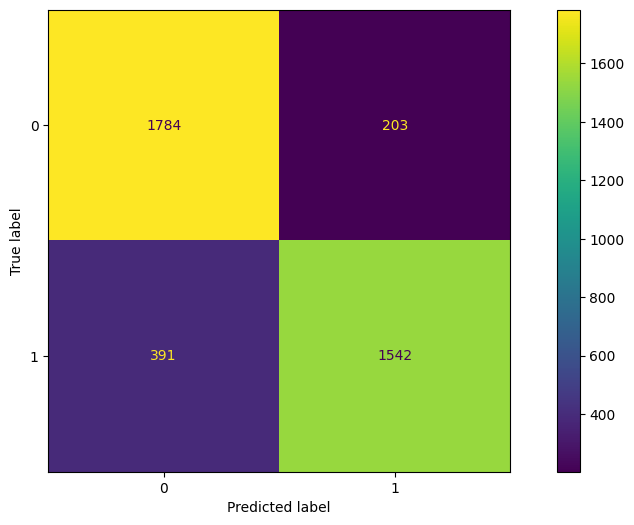

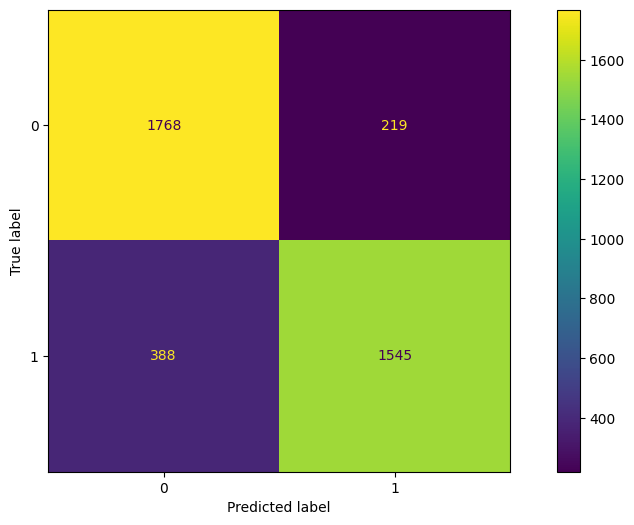

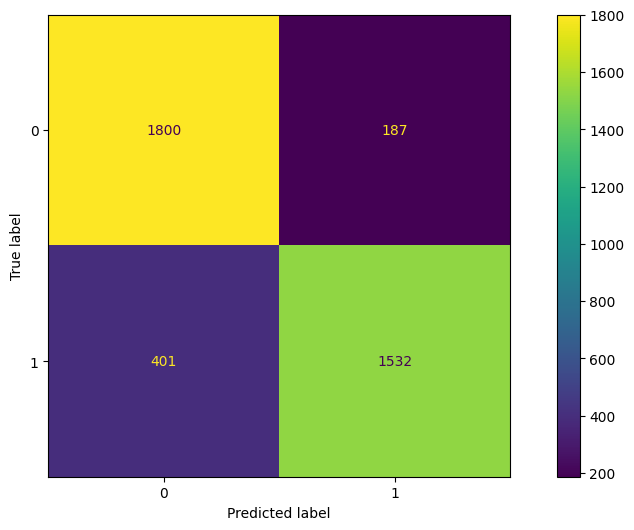

In [43]:
options = [(12,12), (12,12,12), (24,12), (11,11), (12, 6, 3), (24,12,6), (24,12,12), (24, 24, 11), (12,12,12,6), (24,24,24)]
   
for option in options:
    mlp = MLPClassifier(hidden_layer_sizes=option, max_iter=1000, solver='adam', activation='tanh', random_state=277986)

    train_inputs = train_data
    train_classes = train_labels
    test_inputs = test_data
    test_classes = test_labels
    
    start_time = time.time()
    mlp.fit(train_inputs, train_classes.values.ravel())

    predictions_train = mlp.predict(train_inputs)
    predictions_test = mlp.predict(test_inputs)
    end_time = time.time()

    elapsed_time = end_time - start_time

    print("Time: {:.2f} seconds".format(elapsed_time))
    print("Accuracy on train data set: {:.2f}% with layers {}".format(accuracy_score(predictions_train, train_classes) * 100, option))
    print("Accuracy on test data set: {:.2f}% with layers {}".format(accuracy_score(predictions_test, test_classes) * 100, option), end='\n\n')

    cm = confusion_matrix(test_classes, predictions_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)
    disp.plot()


Model, który składa się z trzech warstw ukrytych neuronów (24, 12, 12), 
a także korzysta z aktywacji tanh i solvera adam ma najlepszy wynik 85.26%.

#### Konfiguracje uczenia
Tworzenie konfiguracji uczenia za pomocą paczki Keras to proces definiowania architektury sieci neuronowej, który składa się z sekwencji warstw połączonych ze sobą.

- SGD (Stochastic Gradient Descent) to klasyczny optymalizator, który aktualizuje wagi na podstawie gradientów wyliczonych na małych podzbiorach danych (batchach)
- adam to adaptacyjny optymalizator, który pozwala na dynamiczne regulowanie tempo uczenia w zależności od gradientów
- RMSprop to adaptacyjny optymalizator, podobny do adam, ale bardziej stabilny przy niektórych problemach uczenia

- 'relu' (Rectified Linear Unit) to popularna funkcja aktywacji, która zwraca wartość wejściową, jeśli jest ona dodatnia, a w przeciwnym przypadku zwraca 0. Jest ona popularna w warstwach ukrytych, ponieważ pozwala na szybsze i stabilniejsze uczenie się sieci, a także pomaga w redukcji problemu zanikającego gradientu
- sigmoid to funkcja aktywacji, która zamienia wartości wejściowe na przedział (0, 1). Jest ona popularna w warstwach końcowych, gdy oczekujemy wartości z przedziału [0, 1]
- tanh to funkcja aktywacji, która zamienia wartości wejściowe na przedział (-1, 1). Jest ona popularna w warstwach ukrytych i może pomóc w redukcji problemu zanikającego gradientu.

In [44]:
model = Sequential()

train_inputs = train_data
train_classes = train_labels
test_inputs = test_data
test_classes = test_labels

model.add(Dense(6, input_dim=train_data.shape[1], activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_inputs, train_classes, epochs=500, verbose=0, validation_data=(test_inputs, test_classes))

predictions_train = model.predict(train_inputs).round()
predictions_test = model.predict(test_inputs).round()

print("Accuracy on train data set: {:.2f}%".format(accuracy_score(predictions_train, train_classes) * 100))
print("Accuracy on test data set: {:.2f}%".format(accuracy_score(predictions_test, test_classes) * 100), end='\n\n')

cm = confusion_matrix(test_classes, predictions_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['good', 'bad'])

123/123 [==============================] - 0s 497us/step
Accuracy on train data set: 84.73%
Accuracy on test data set: 84.16%



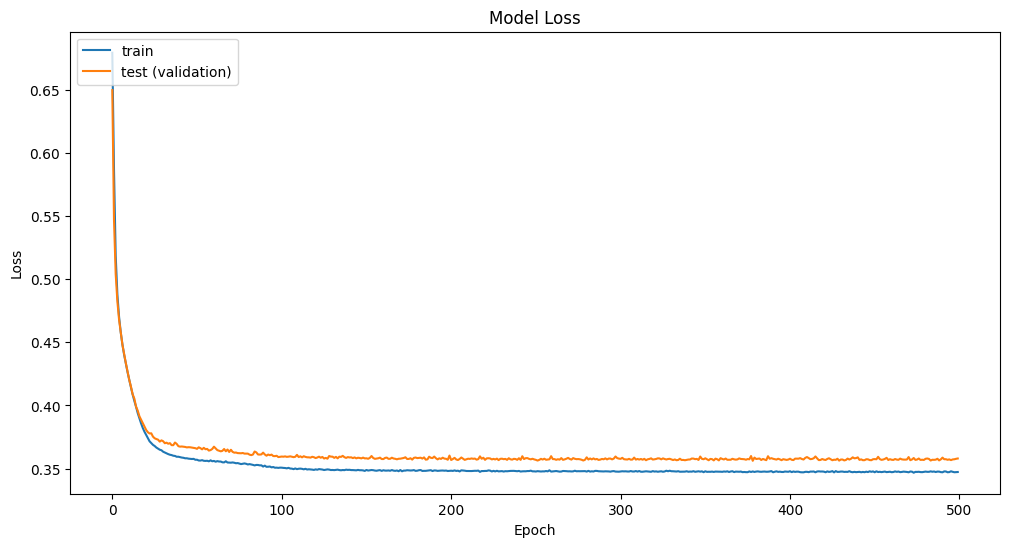

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test (validation)'], loc='upper left')
plt.show()

In [46]:
model = Sequential()

train_inputs = train_data
train_classes = train_labels
test_inputs = test_data
test_classes = test_labels

model.add(Dense(6, input_dim=train_data.shape[1], activation='tanh'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_inputs, train_classes, epochs=500, verbose=0, validation_data=(test_inputs, test_classes))

predictions_train = model.predict(train_inputs).round()
predictions_test = model.predict(test_inputs).round()

print("Accuracy on train data set: {:.2f}%".format(accuracy_score(predictions_train, train_classes) * 100))
print("Accuracy on test data set: {:.2f}%".format(accuracy_score(predictions_test, test_classes) * 100), end='\n\n')

cm = confusion_matrix(test_classes, predictions_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['good', 'bad'])

123/123 [==============================] - 0s 494us/step
Accuracy on train data set: 85.39%
Accuracy on test data set: 85.15%



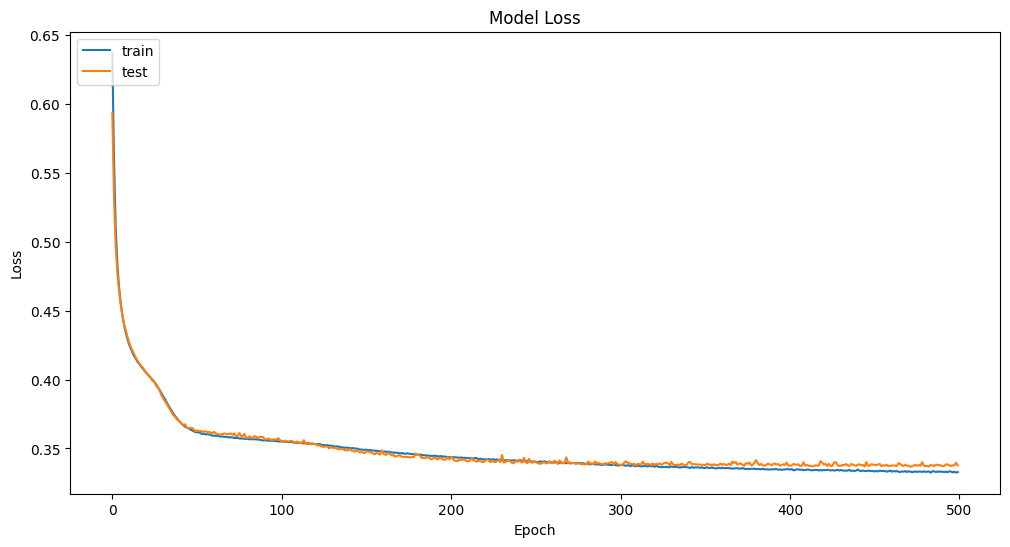

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

123/123 [==============================] - 0s 491us/step
Time: 131.65 seconds
Accuracy on train data set: 81.72% with layers ['sgd', 'sigmoid']
Accuracy on test data set: 81.99% with layers ['sgd', 'sigmoid']



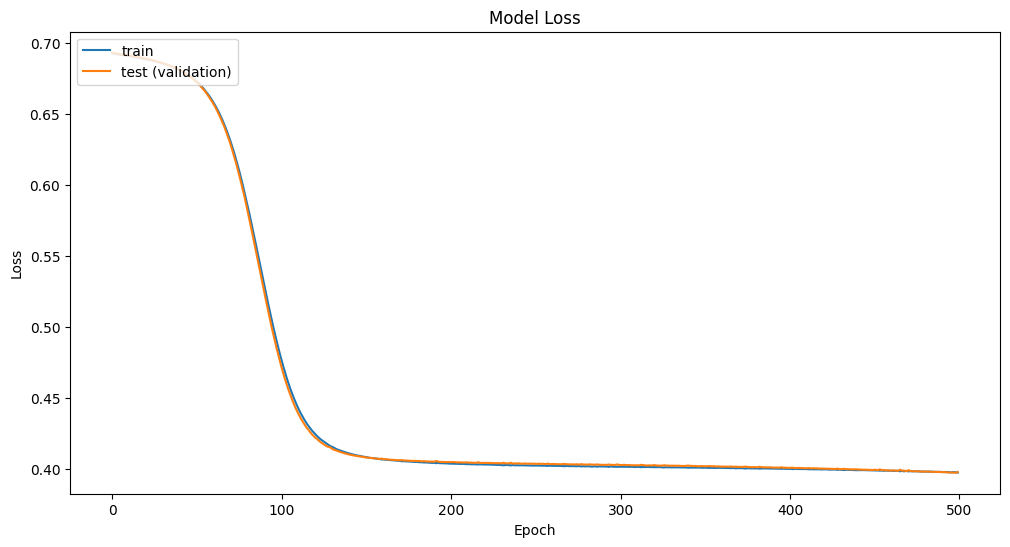

123/123 [==============================] - 0s 494us/step
Time: 139.04 seconds
Accuracy on train data set: 84.67% with layers ['adam', 'sigmoid']
Accuracy on test data set: 84.67% with layers ['adam', 'sigmoid']



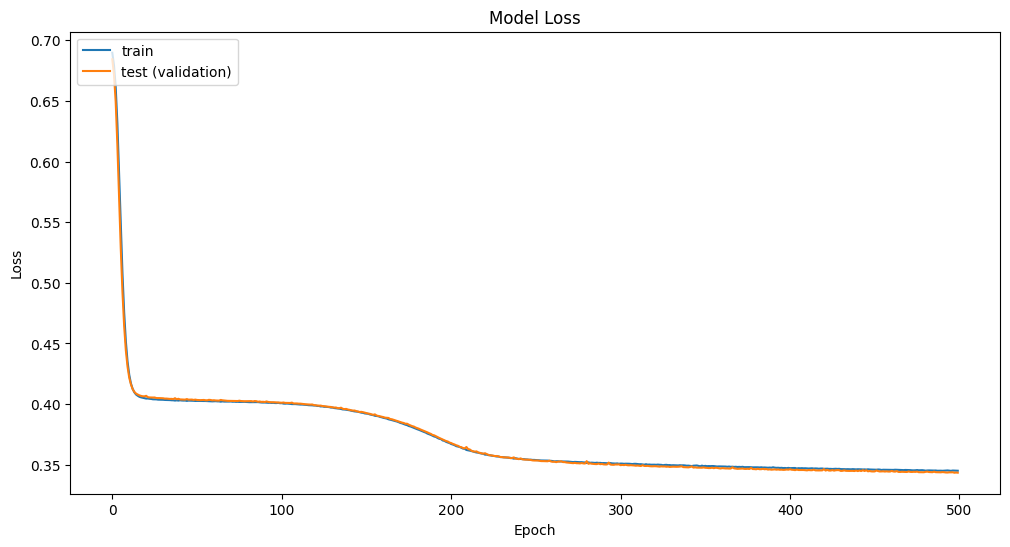

123/123 [==============================] - 0s 500us/step
Time: 129.16 seconds
Accuracy on train data set: 85.22% with layers ['rmsprop', 'tanh']
Accuracy on test data set: 84.95% with layers ['rmsprop', 'tanh']



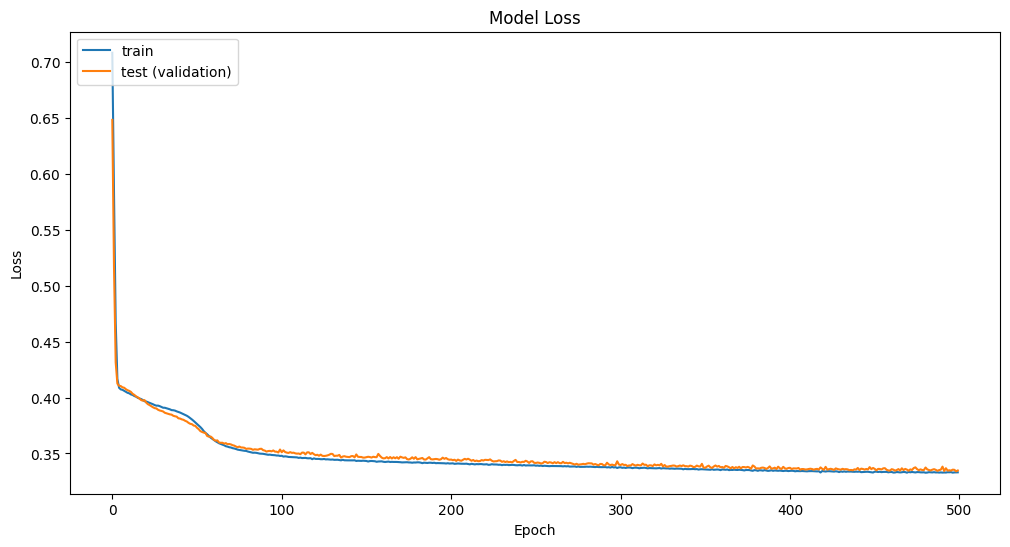

In [48]:
options = [['sgd', 'sigmoid'], ['adam', 'sigmoid'], ['rmsprop', 'tanh']]
for option in options:
    model = Sequential()
    train_inputs = train_data
    train_classes = train_labels
    test_inputs = test_data
    test_classes = test_labels
    
    start_time = time.time()
            
    model.add(Dense(6, activation=option[1], input_dim=train_inputs.shape[1]))
    model.add(Dense(3, activation=option[1]))
    model.add(Dense(1, activation='sigmoid'))
    
    mlp.fit(train_inputs, train_classes.values.ravel())
    
    model.compile(loss='binary_crossentropy', optimizer=option[0], metrics=['accuracy'])
    history = model.fit(train_inputs, train_classes, epochs=500, verbose=0, validation_data=(test_inputs, test_classes))

    predictions_train = model.predict(train_inputs).round()
    predictions_test = model.predict(test_inputs).round()
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print("Time: {:.2f} seconds".format(elapsed_time))
    print("Accuracy on train data set: {:.2f}% with layers {}".format(accuracy_score(predictions_train, train_classes) * 100, option))
    print("Accuracy on test data set: {:.2f}% with layers {}".format(accuracy_score(predictions_test, test_classes) * 100, option), end='\n\n')
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test (validation)'], loc='upper left')
    plt.show()

Wszystkie powyższe wykresy wskazują na dobre dopasowanie. Krzywe starty zbioru treningowego i walidacji spadają do punktu stabilności i mają między sobą niewielkie różnice. Dalsze uczenie dobrze dopasowanego modelu mogłoby poprowadzić do modelu zbyt dopasowanego (overfitting).

#### Inny, prostszy preprocessing datasetu

In [49]:
df_copy_2 = df.copy()

In [50]:
df_copy_2.isna().sum().sum()

1080

In [51]:
find_outliers_z_score(df_copy_2['height_cm'])
find_outliers_z_score(df_copy_2['weight_kg'])
find_outliers_z_score(df_copy_2['body fat_%'])
find_outliers_z_score(df_copy_2['gripForce'])
find_outliers_z_score(df_copy_2['sit and bend forward_cm'])
find_outliers_z_score(df_copy_2['sit-ups counts'])
find_outliers_z_score(df_copy_2['broad jump_cm'])
find_outliers_z_score(df_copy_2['diastolic'])
find_outliers_z_score(df_copy_2['systolic'])

In [52]:
df_copy_2.isna().sum().sum()

1441

In [53]:
df_copy_2.dropna(inplace=True)
df_copy_2.isna().sum().sum()

0

hot-encoding

In [54]:
df_copy_2['gender'] = df_copy_2['gender'].map({'F': 0, 'M': 1})
df_copy_2['class'] = df_copy_2['class'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3})

StandardScaler dokonuje przeskalowania danych w taki sposób, aby ich średnia wartość wynosiła 0 oraz odchylenie standardowe wynosiło 1. To oznacza, że wartości danych są przeskalowane w taki sposób, aby miały podobną skalę i wpływ na model uczący.

In [55]:
X = df_copy_2.drop('class', axis=1)

le = LabelEncoder()
df_copy_2['class'] = le.fit_transform(df_copy_2['class'])
y = df_copy_2['class']


scaler = StandardScaler()
X = scaler.fit_transform(X)
X.shape

(11710, 11)

In [56]:
(train_data, test_data, train_labels, test_labels) = train_test_split(X, y, train_size=0.7, random_state=277986)

DD Accuracy: 66.13%


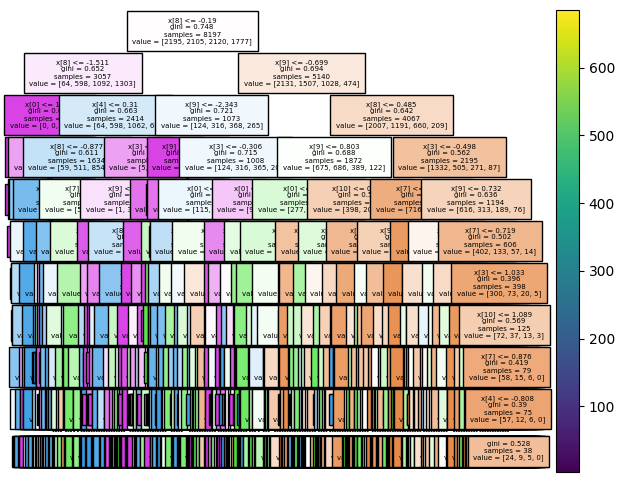

In [57]:
tree_classifier = DecisionTreeClassifier(random_state=277986, max_depth=10)

train_inputs = train_data
train_classes = train_labels
test_inputs = test_data
test_classes = test_labels

tree_classifier.fit(train_inputs, train_classes)

tree_predictions = tree_classifier.predict(test_inputs)
tree_accuracy = accuracy_score(test_classes, tree_predictions)
tree_cm = confusion_matrix(test_classes, tree_predictions)

print("DD Accuracy: {:.2f}%".format(tree_accuracy * 100))

predictions = tree_classifier.predict(test_inputs)
cm = confusion_matrix(test_classes, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree_classifier.classes_)
disp.plot()

plot_tree(tree_classifier, filled=True, fontsize=5)
plt.show()

DD Accuracy: 53.32%


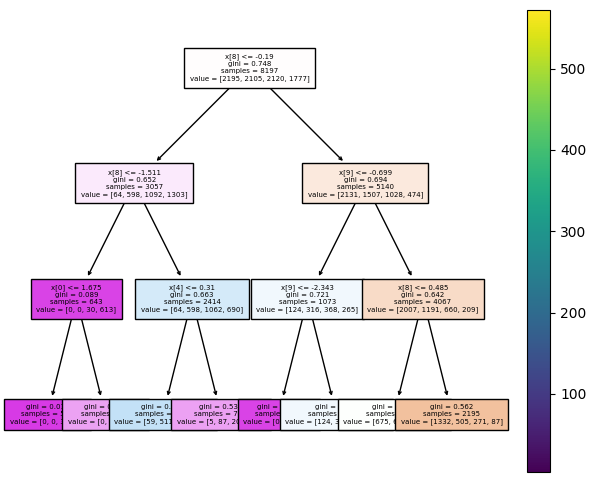

In [58]:
tree_classifier = DecisionTreeClassifier(random_state=277986, max_depth=3)

train_inputs = train_data
train_classes = train_labels
test_inputs = test_data
test_classes = test_labels

tree_classifier.fit(train_inputs, train_classes)

tree_predictions = tree_classifier.predict(test_inputs)
tree_accuracy = accuracy_score(test_classes, tree_predictions)
tree_cm = confusion_matrix(test_classes, tree_predictions)

print("DD Accuracy: {:.2f}%".format(tree_accuracy * 100))

predictions = tree_classifier.predict(test_inputs)
cm = confusion_matrix(test_classes, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree_classifier.classes_)
disp.plot()

plot_tree(tree_classifier, filled=True, fontsize=5)
plt.show()

Naive Bayes Accuracy: 52.97%


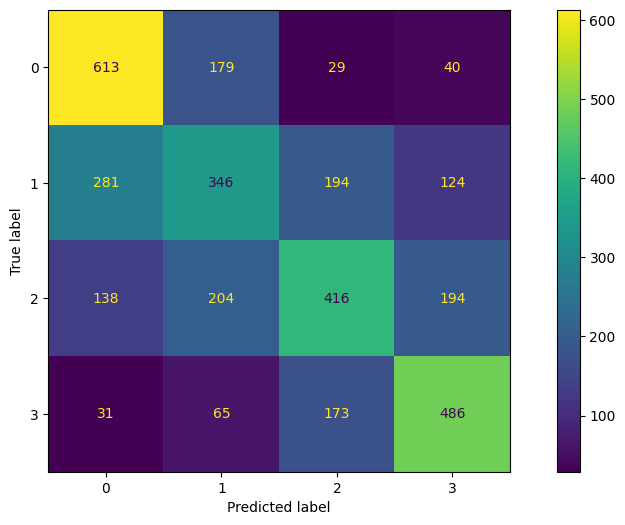

In [59]:
nb = GaussianNB()

train_inputs = train_data
train_classes = train_labels
test_inputs = test_data
test_classes = test_labels

nb.fit(train_inputs, train_classes)
nb_predictions = nb.predict(test_inputs)
nb_accuracy = accuracy_score(test_classes, nb_predictions)
nb_cm = confusion_matrix(test_classes, nb_predictions)

print("Naive Bayes Accuracy: {:.2f}%".format(nb_accuracy * 100))

predictions = nb.predict(test_inputs)
cm = confusion_matrix(test_classes, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb.classes_)
disp.plot()

3-NN Accuracy: 55.54%


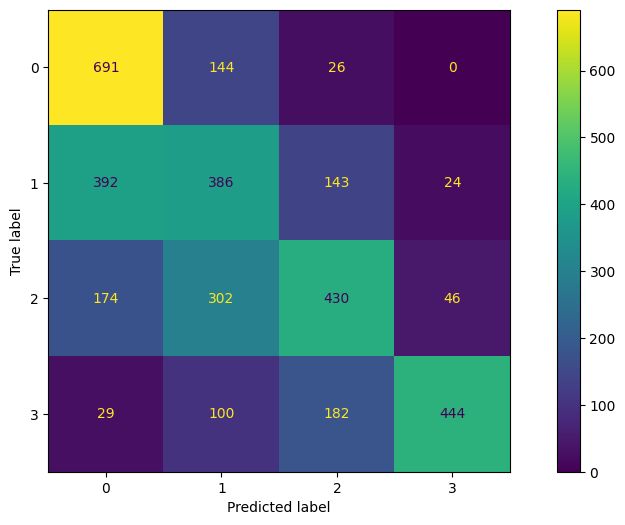

In [60]:
knn_3 = KNeighborsClassifier(n_neighbors=3)

train_inputs = train_data
train_classes = train_labels
test_inputs = test_data
test_classes = test_labels

knn_3.fit(train_inputs, train_classes)
knn_3_predictions = knn_3.predict(test_inputs)
knn_3_accuracy = accuracy_score(test_classes, knn_3_predictions)
knn_3_cm = confusion_matrix(test_classes, knn_3_predictions)

print("3-NN Accuracy: {:.2f}%".format(knn_3_accuracy * 100))

predictions = knn_3.predict(test_inputs)
cm = confusion_matrix(test_classes, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_3.classes_)
disp.plot()

5-NN Accuracy: 57.42%


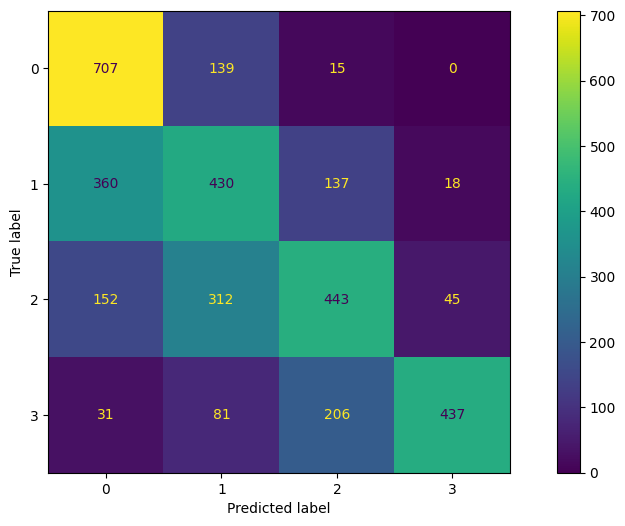

In [61]:
knn_5 = KNeighborsClassifier(n_neighbors=5)

train_inputs = train_data
train_classes = train_labels
test_inputs = test_data
test_classes = test_labels

knn_5.fit(train_inputs, train_classes)
knn_5_predictions = knn_5.predict(test_inputs)
knn_5_accuracy = accuracy_score(test_classes, knn_5_predictions)
knn_5_cm = confusion_matrix(test_classes, knn_5_predictions)

print("5-NN Accuracy: {:.2f}%".format(knn_5_accuracy * 100))

predictions = knn_5.predict(test_inputs)
cm = confusion_matrix(test_classes, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_5.classes_)
disp.plot()

11-NN Accuracy: 59.78%


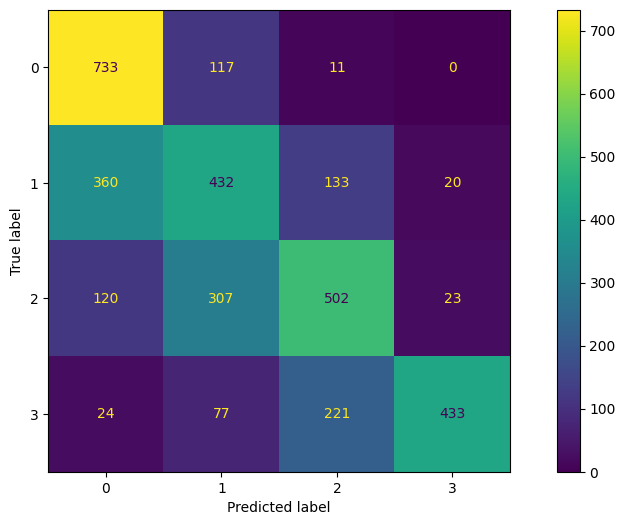

In [62]:
knn_11 = KNeighborsClassifier(n_neighbors=11)

train_inputs = train_data
train_classes = train_labels
test_inputs = test_data
test_classes = test_labels

knn_11.fit(train_inputs, train_classes)
knn_11_predictions = knn_11.predict(test_inputs)
knn_11_accuracy = accuracy_score(test_classes, knn_11_predictions)
knn_11_cm = confusion_matrix(test_classes, knn_11_predictions)

print("11-NN Accuracy: {:.2f}%".format(knn_11_accuracy * 100))

predictions = knn_11.predict(test_inputs)
cm = confusion_matrix(test_classes, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_11.classes_)
disp.plot()

Time: 7.15 seconds
Accuracy on train data set: 71.84% with options ['relu', 'adam']
Accuracy on test data set: 68.63% with options ['relu', 'adam']

Time: 7.34 seconds
Accuracy on train data set: 72.98% with options ['tanh', 'adam']
Accuracy on test data set: 70.08% with options ['tanh', 'adam']

Time: 2.61 seconds
Accuracy on train data set: 72.22% with options ['relu', 'lbfgs']
Accuracy on test data set: 68.89% with options ['relu', 'lbfgs']



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Time: 8.18 seconds
Accuracy on train data set: 74.00% with options ['tanh', 'lbfgs']
Accuracy on test data set: 70.79% with options ['tanh', 'lbfgs']



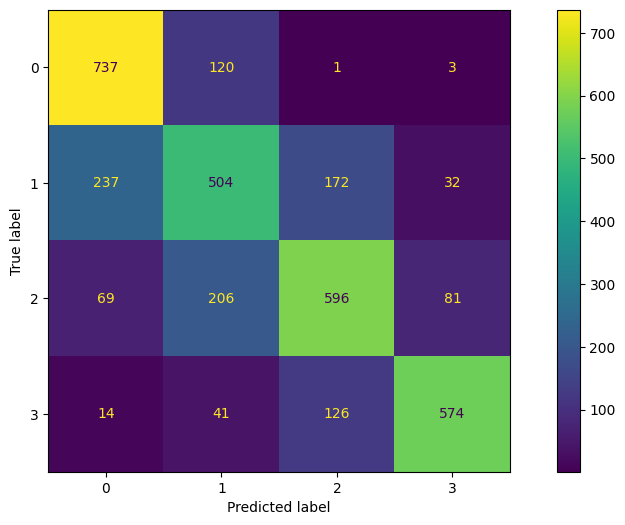

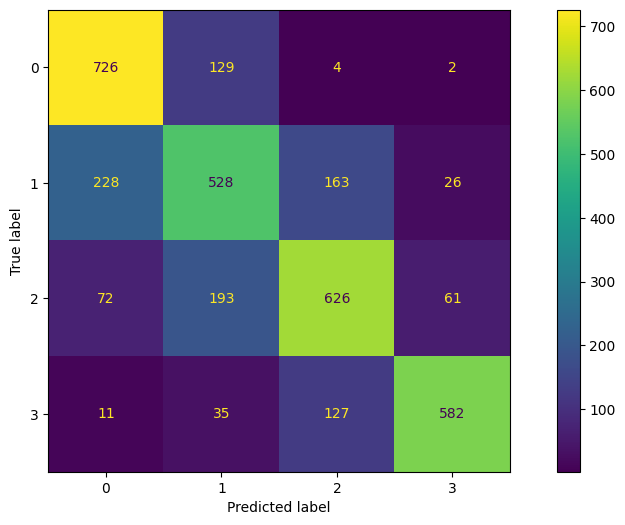

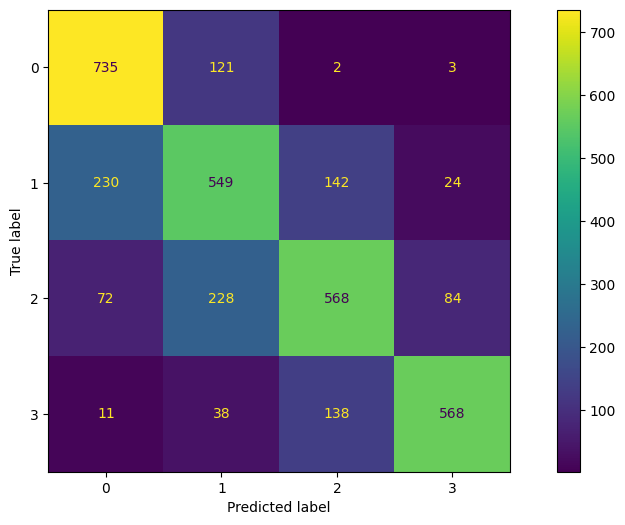

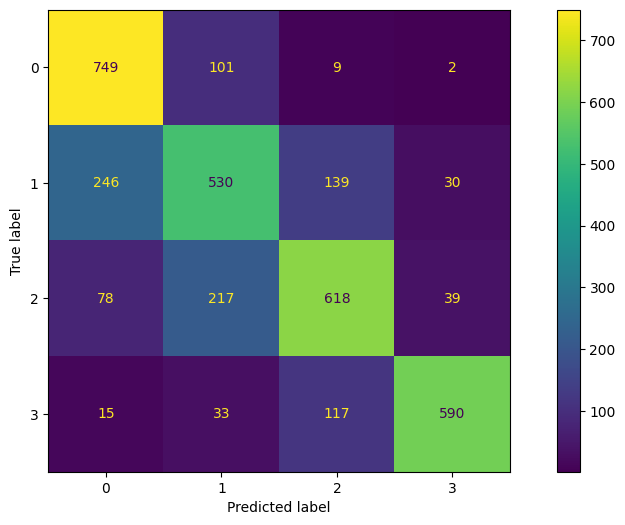

In [63]:
options = [['relu', 'adam'], ['tanh', 'adam'], ['relu', 'lbfgs'], ['tanh', 'lbfgs']]

for option in options:
    mlp = MLPClassifier(hidden_layer_sizes=(6,), max_iter=3000, activation=option[0], solver=option[1], random_state=277986)

    train_inputs = train_data
    train_classes = train_labels
    test_inputs = test_data
    test_classes = test_labels
    
    start_time = time.time()
    mlp.fit(train_inputs, train_classes.values.ravel())
    
    predictions_train = mlp.predict(train_inputs)
    predictions_test = mlp.predict(test_inputs)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print("Time: {:.2f} seconds".format(elapsed_time))
    print("Accuracy on train data set: {:.2f}% with options {}".format(accuracy_score(predictions_train, train_classes) * 100, option))
    print("Accuracy on test data set: {:.2f}% with options {}".format(accuracy_score(predictions_test, test_classes) * 100, option), end='\n\n')


    cm = confusion_matrix(test_classes, predictions_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)
    disp.plot()

Time: 5.84 seconds
Accuracy on train data set: 75.91% with layers (12, 12)
Accuracy on test data set: 72.19% with layers (12, 12)

Time: 5.23 seconds
Accuracy on train data set: 76.93% with layers (12, 12, 12)
Accuracy on test data set: 73.07% with layers (12, 12, 12)

Time: 9.58 seconds
Accuracy on train data set: 78.46% with layers (24, 12)
Accuracy on test data set: 72.79% with layers (24, 12)

Time: 6.82 seconds
Accuracy on train data set: 75.64% with layers (11, 11)
Accuracy on test data set: 72.39% with layers (11, 11)

Time: 8.13 seconds
Accuracy on train data set: 76.02% with layers (12, 6, 3)
Accuracy on test data set: 71.65% with layers (12, 6, 3)

Time: 5.88 seconds
Accuracy on train data set: 77.16% with layers (24, 12, 6)
Accuracy on test data set: 72.79% with layers (24, 12, 6)

Time: 7.23 seconds
Accuracy on train data set: 77.96% with layers (24, 12, 12)
Accuracy on test data set: 71.99% with layers (24, 12, 12)

Time: 9.08 seconds
Accuracy on train data set: 79.36% wit

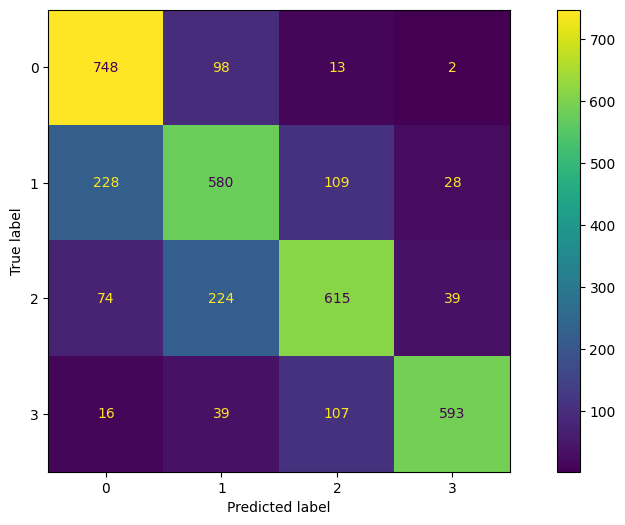

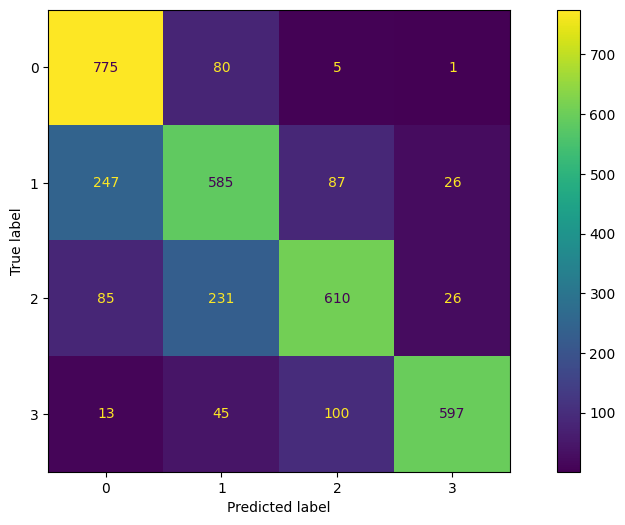

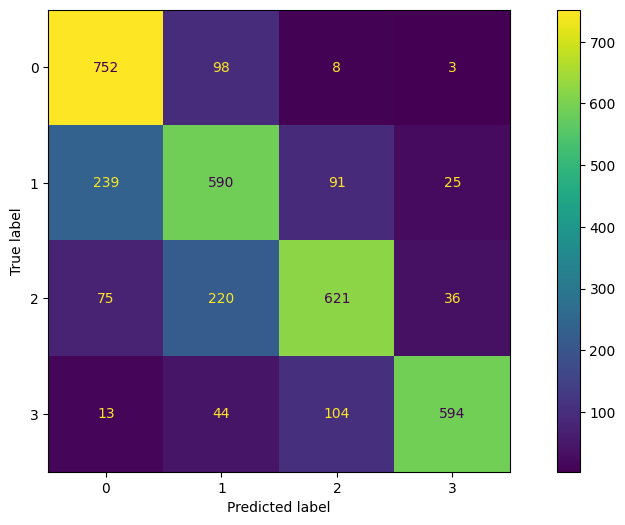

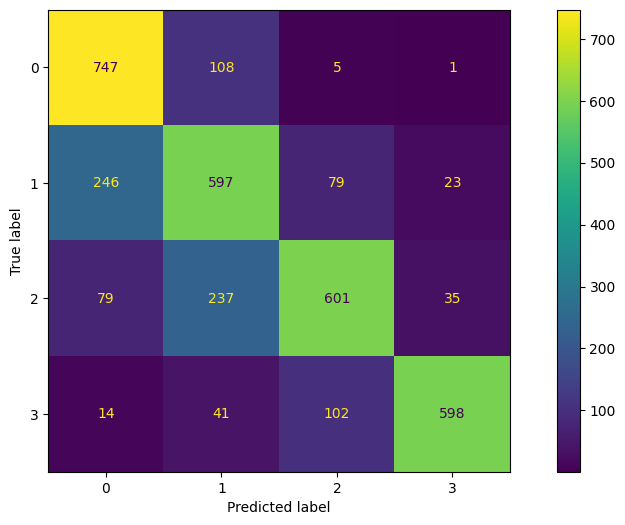

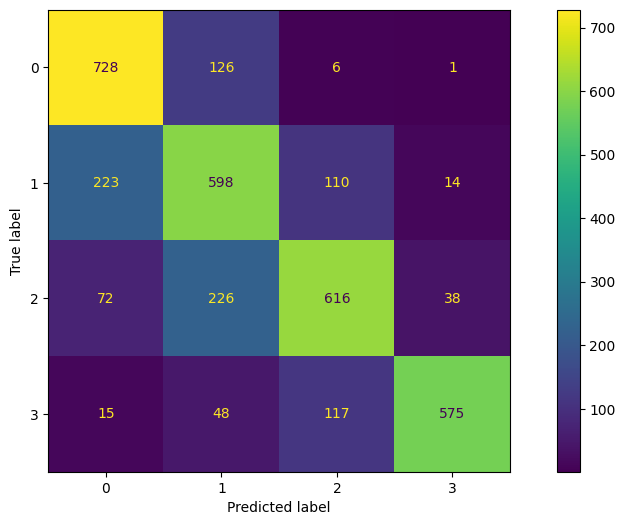

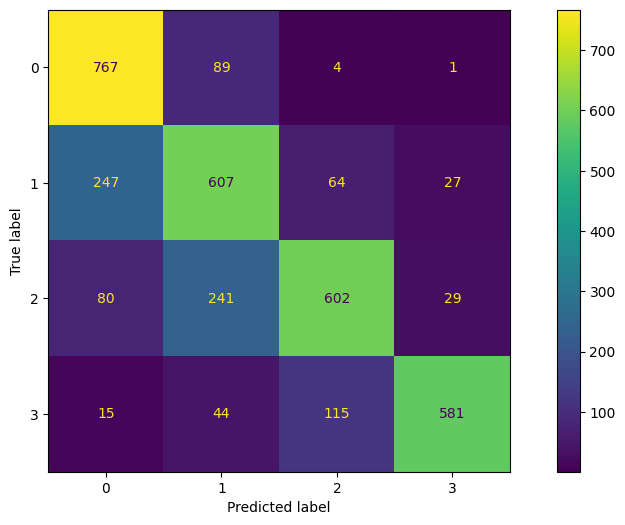

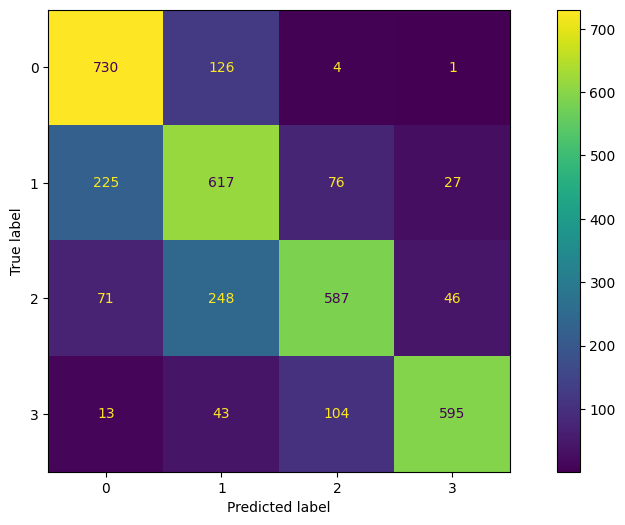

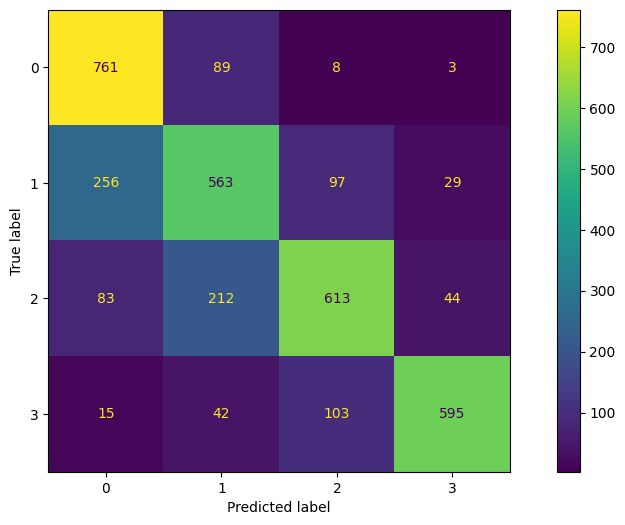

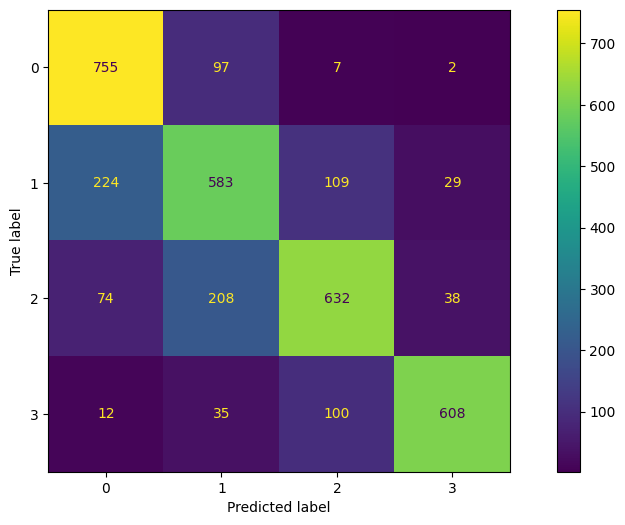

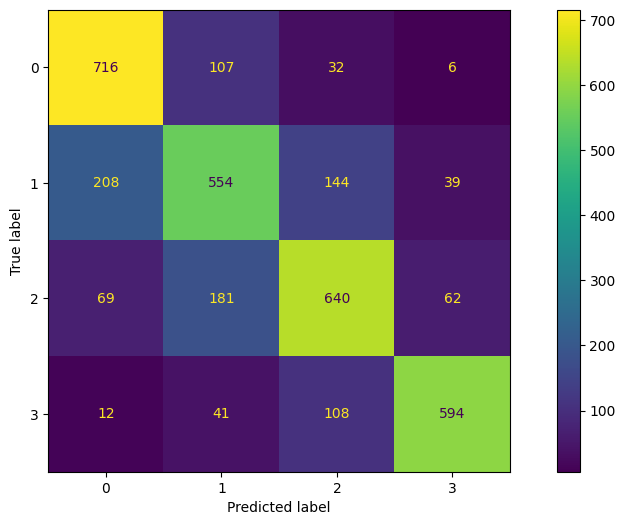

In [64]:
options = [(12,12), (12,12,12), (24,12), (11,11), (12, 6, 3), (24,12,6), (24,12,12), (24, 24, 11), (12,12,12,6), (24,24,24)]
   
for option in options:
    mlp = MLPClassifier(hidden_layer_sizes=option, max_iter=1000, solver='adam', activation='tanh', random_state=277986)

    train_inputs = train_data
    train_classes = train_labels
    test_inputs = test_data
    test_classes = test_labels
    
    start_time = time.time()
    mlp.fit(train_inputs, train_classes.values.ravel())

    predictions_train = mlp.predict(train_inputs)
    predictions_test = mlp.predict(test_inputs)
    end_time = time.time()

    elapsed_time = end_time - start_time

    print("Time: {:.2f} seconds".format(elapsed_time))
    print("Accuracy on train data set: {:.2f}% with layers {}".format(accuracy_score(predictions_train, train_classes) * 100, option))
    print("Accuracy on test data set: {:.2f}% with layers {}".format(accuracy_score(predictions_test, test_classes) * 100, option), end='\n\n')

    cm = confusion_matrix(test_classes, predictions_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)
    disp.plot()

110/110 [==============================] - 0s 524us/step
Accuracy on train data set: 75.59%
Accuracy on test data set: 72.16%


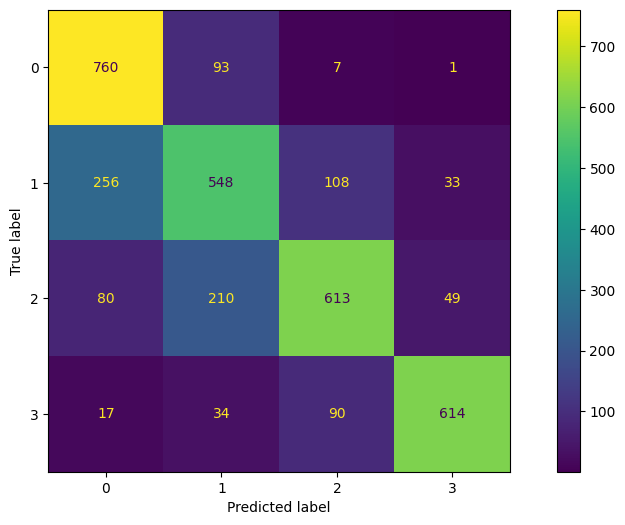

In [65]:
model = Sequential()

train_inputs = train_data
train_classes = train_labels
test_inputs = test_data
test_classes = test_labels

model.add(Dense(11, input_dim=train_inputs.shape[1], activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(4, activation='sigmoid'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_inputs, train_classes, epochs=500, verbose=0, validation_data=(test_inputs, test_classes))

predictions_train = np.argmax(model.predict(train_inputs), axis=-1)
predictions_test = np.argmax(model.predict(test_inputs), axis=-1)

print("Accuracy on train data set: {:.2f}%".format(accuracy_score(predictions_train, train_classes) * 100))
print("Accuracy on test data set: {:.2f}%".format(accuracy_score(predictions_test, test_classes) * 100))

cm = confusion_matrix(test_classes, predictions_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)
disp.plot()

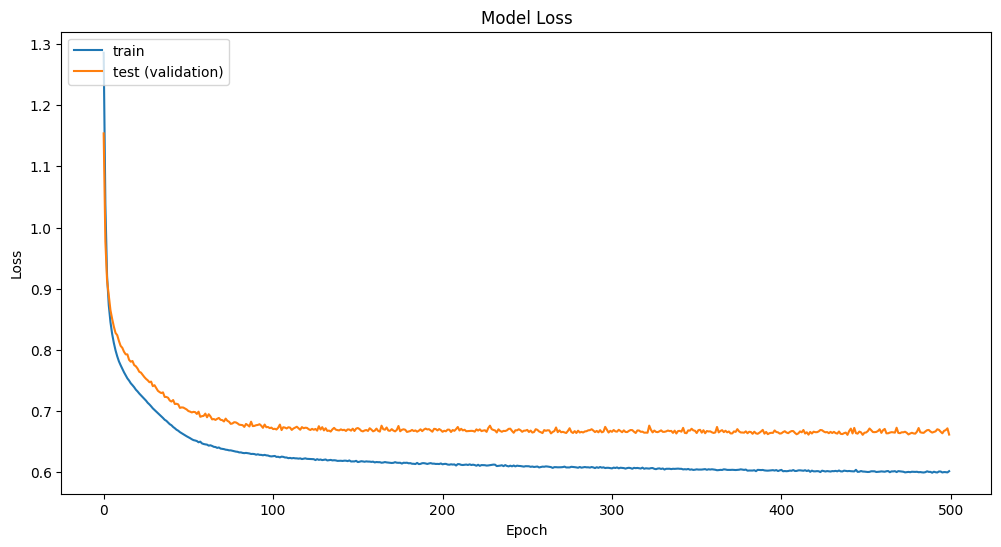

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test (validation)'], loc='upper left')
plt.show()

110/110 [==============================] - 0s 531us/step
Time: 141.41 seconds
Accuracy on train data set: 69.09% with layers ['sgd', 'sigmoid']
Accuracy on test data set: 64.99% with layers ['sgd', 'sigmoid']



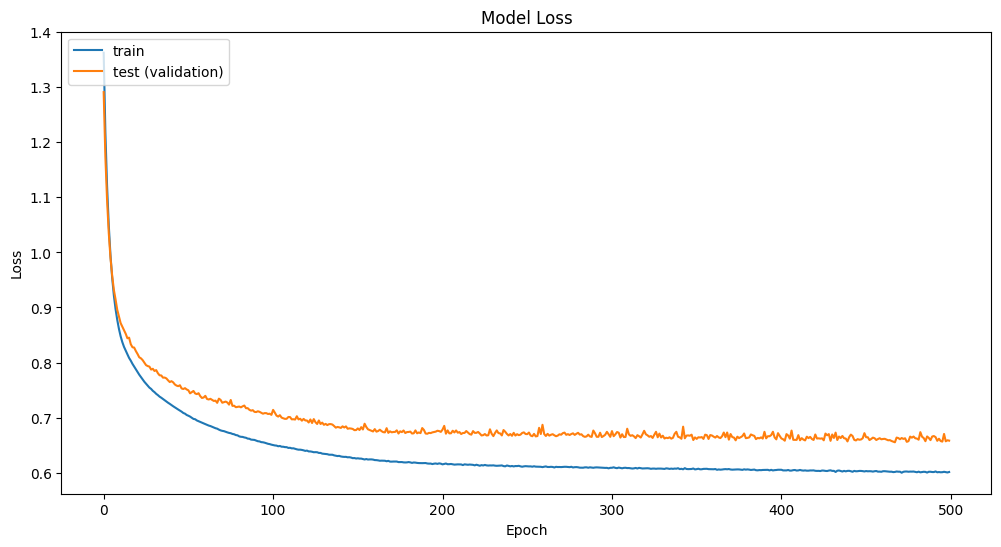

110/110 [==============================] - 0s 570us/step
Time: 146.38 seconds
Accuracy on train data set: 75.43% with layers ['adam', 'sigmoid']
Accuracy on test data set: 71.05% with layers ['adam', 'sigmoid']



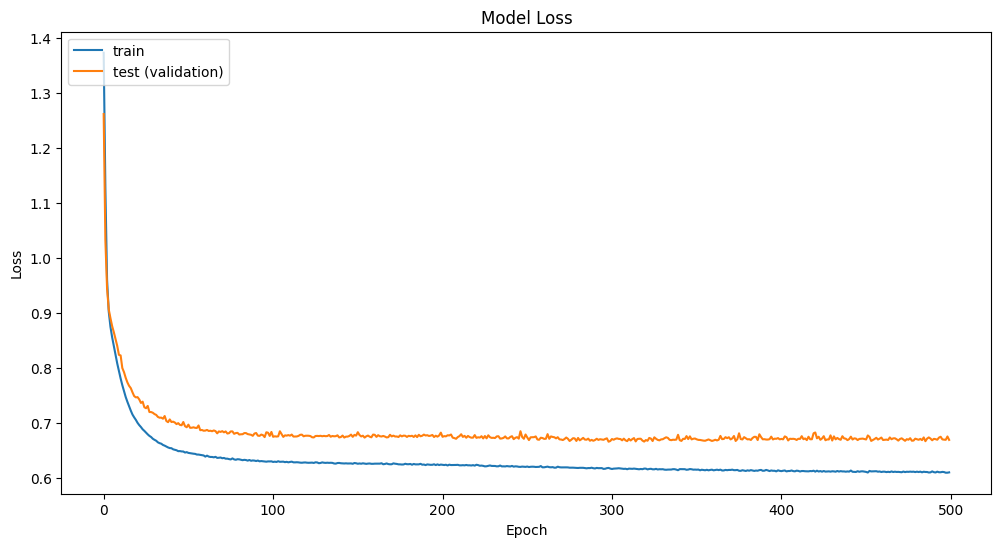

110/110 [==============================] - 0s 576us/step
Time: 137.16 seconds
Accuracy on train data set: 75.13% with layers ['rmsprop', 'tanh']
Accuracy on test data set: 71.11% with layers ['rmsprop', 'tanh']



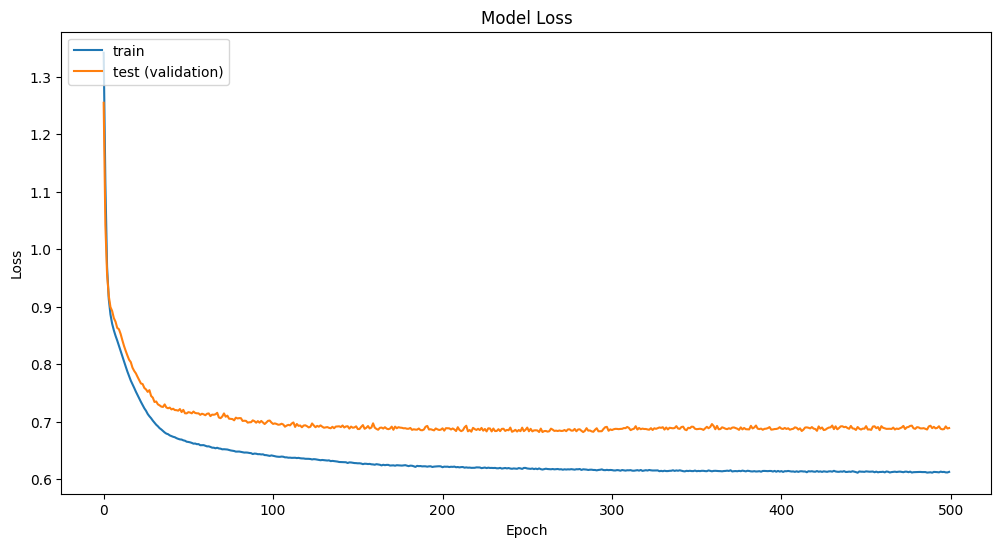

In [67]:
options = [['sgd', 'sigmoid'], ['adam', 'sigmoid'], ['rmsprop', 'tanh']]
for option in options:
    model = Sequential()
    
    train_inputs = train_data
    train_classes = train_labels
    test_inputs = test_data
    test_classes = test_labels
    
    start_time = time.time()
            
    model.add(Dense(11, input_dim=train_inputs.shape[1], activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(4, activation='sigmoid'))
    
    mlp.fit(train_inputs, train_classes.values.ravel())
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=option[0], metrics=['accuracy'])
    history = model.fit(train_inputs, train_classes, epochs=500, verbose=0, validation_data=(test_inputs, test_classes))

    predictions_train = np.argmax(model.predict(train_inputs), axis=-1)
    predictions_test = np.argmax(model.predict(test_inputs), axis=-1)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print("Time: {:.2f} seconds".format(elapsed_time))
    print("Accuracy on train data set: {:.2f}% with layers {}".format(accuracy_score(predictions_train, train_classes) * 100, option))
    print("Accuracy on test data set: {:.2f}% with layers {}".format(accuracy_score(predictions_test, test_classes) * 100, option), end='\n\n')
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test (validation)'], loc='upper left')
    plt.show()

Powyższe wykresy wskazuja, że dopasowanie nie jest do końca reprezentatywne. Krzywa uczenia dla straty treningowej oraz krzywa uczenia dla straty walidacyjnej pokazują poprawę, ale istnieje duża różnica pomiędzy obiema krzywymi.

#### Podsumowanie

Podczas analizy danych i ich przygotowania (preprocessingu), zrozumienie danych, z którymi pracujemy, odgrywa kluczową rolę. Jest to niezwykle istotne dla skutecznego modelowania i uzyskania trafnych wyników. Podczas przeprowadzania eksperymentów z różnymi parametrami modelu, ważne jest również zrozumienie, jak poszczególne parametry wpływają na wyniki. Dzięki metodzie prób i błędów oraz dogłębnemu zrozumieniu parametrów modelu, możemy osiągnąć lepsze rezultaty predykcji. Dobór optymalnych parametrów stanowi więc istotny etap w procesie tworzenia modeli.

Aby wykazać różnicę między preprocessowaniem w dwóch wersjach, zdecydowałam się na zastosowanie określonych technik w każdej z nich. W pierwszej wersji, w celu usuwania wartości odstających, zastosowałam indeks z (z-score), co pozwoliło na identyfikację i usunięcie obserwacji odstających. Następnie, aby wypełnić brakujące wartości, użyłam imputacji KNN (K-Nearest Neighbors), co pozwoliło na przypisanie odpowiednich wartości zerowym obserwacjom. Zauważyłam także relacje między dwiema kolumnami i połączyłam je w jedną, tworząc nową zmienną, tj. BMI. Następnie zastosowałam kodowanie gorące (hot encoding), aby zakodować zmienne kategoryczne, oraz połączyłam odpowiednie kolumny w celu klasyfikacji, która miała odpowiedzieć na pytanie, czy osoba ma dobrą sprawność fizyczną. Ponieważ nie istnieje ogólnie przyjęta oficjalna klasyfikacja, zdecydowałam się na połączenie 2 klas w 1. Aby doprowadzić dane do jednolitej skali, zastosowałam normalizację min-max oraz PCA (Principal Component Analysis).

W drugiej wersji, w celu wykrycia wartości odstających, również skorzystałam z indeksu z. W prosty sposób usunęłam wszystkie wiersze zawierające przynajmniej jedną wartość brakującą. Następnie zastosowałam kodowanie gorące oraz przeskalowanie danych za pomocą standard scaler. W tej wersji pozostawiłam 4 klasy, aby pokazać większą różnicę między przetworzonymi danymi. Pierwotnie, gdy w obu wersjach pozostawiłam 4 klasy klasyfikacji, różnice były niewielkie, około jednego punktu procentowego, na korzyść pierwszego preprocessingu.

W przedstawionej tabeli widać, że preprocessowanie stanowi istotny element w klasyfikacji, a skuteczność można poprawić, wykonując nieco więcej operacji, aby osiągnąć oczekiwane rezultaty.

Dla obu sposobów preprocessingu najlepsze wyniki dawały sieci neuronowe.

Wnioski z tych obserwacji sugerują, że staranne preprocessowanie danych może mieć istotny wpływ na wyniki klasyfikacji. Wykorzystanie odpowiednich technik, takich jak usuwanie outliersów, imputacja brakujących danych, kodowanie kategorycznych zmiennych, normalizacja i przeskalowanie danych, może prowadzić do poprawy jakości modelu i uzyskania bardziej precyzyjnych wyników predykcji.

##### Najlepsze wyniki dla każdego modelu

| Model     | preprocessing 1 | preprocessing 2 |
| --------- | -------- | ----------- |
| Drzewo    |          |             |
| depth=10  | 79.34%   | 66.13%      |
| depth=3   | 77.5%    | 53.32%      |
| Naive Bayes | 82.5%    |  52.97%     |
| KNN       |          |             |
| K=3       | 80.41%   | 55.54%      |
| K=5       | 81.91%   | 57.42%      |
| K=11      | 82.55%   | 59.78%      |
| MLP       | 85%      | 73.38%      |
| Konfiguracja uczenia | 85.28% | 71.11%   |


##### Bibliografia
- https://www.bigdata-culture.kr/bigdata/user/data_market/detail.do?id=ace0aea7-5eee-48b9-b616-637365d665c1
- https://www.benenden.co.uk/be-healthy/body/blood-pressure-know-your-numbers/ (blood pressure chart)
- https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/
- https://careerfoundry.com/en/blog/data-analytics/how-to-find-outliers/
- https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/